Importovanje biblioteka

In [1]:
import pandas 
import requests
import urllib.parse
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import seaborn as sb
import matplotlib.pyplot as plt

Ucitavanje svih potrebnih fajlova

In [2]:
dfTarget = pandas.read_csv('dataset/objects.csv',low_memory=False) # fajl u kom se nalazi ciljno obiljezje
dfDegrees=pandas.read_csv('dataset/degrees.csv',low_memory=False) # fajl u kome se nalaze podaci o diplomama zaposlenih 
dfRelationship=pandas.read_csv('dataset/relationships.csv',low_memory=False) # fajl koji predstavlja medju tabelu koja povezuje zaposlene sa startapima
dfOffices=pandas.read_csv('dataset/offices.csv',low_memory=False)

print('Reading csv files is done...')

Reading csv files is done...


In [3]:
dfRelationship = dfRelationship.drop(columns=['id','relationship_id','start_at','end_at','is_past','sequence','created_at','updated_at'])

In [4]:
dfDegrees = dfDegrees.drop(columns=['id','graduated_at','created_at','updated_at'])

In [5]:
dfRelationship = dfRelationship.merge(dfDegrees,
                   on = "person_object_id", 
                   how = 'right')

In [6]:

dfRelationship.relationship_object_id = dfRelationship.relationship_object_id.fillna('')
dfRelationship.title = dfRelationship.title.fillna('')
dfRelationship.drop(dfRelationship[(dfRelationship.relationship_object_id)==''].index,inplace=True)

In [7]:
dfRelationship.drop(dfRelationship[~(dfRelationship["title"].str.contains('CEO') | dfRelationship["title"].str.contains('President') | (dfRelationship["title"].str.contains('Founder')))].index,inplace=True)

In [8]:
dfRelationship = dfRelationship.drop_duplicates(subset=['relationship_object_id'])

In [9]:
dfRelationship.institution = dfRelationship.institution.fillna('')
dfRelationship.drop(dfRelationship[(dfRelationship.institution)==''].index,inplace=True)

In [10]:
dfRelationship.rename(columns={'relationship_object_id': 'object_id'}, inplace=True)

# Scraping sajta "World University Rankings 2022-23"

In [11]:
session = requests.Session()
session.headers.update({
   'User-Agent': 'Mozilla/5.0 (Windows NT 10.0;Win64) AppleWebkit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.82 '
                 'Safari/537.36'})

url = 'https://cwur.org/2022-23.php'
page = session.get(url)
soup = BeautifulSoup(page.content, 'html.parser')

thead = soup.find('thead')
headings = thead.find_all('th')
attributes = [heading.text for heading in headings]

tbody = soup.find('tbody')
rows = tbody.find_all('tr')

data = []
for row in rows:
    cells = row.find_all('td')
    values = [cell.text for cell in cells]
    row_data = dict(zip(attributes, values))
    data.append(row_data)

dfUnivercity = pandas.DataFrame(data)
dfUnivercity.to_csv('cwur_universities.csv', index=True)
dfUnivercity

,World Rank,Institution,Location,National Rank,Education Rank,Employability Rank,Faculty Rank,Research Rank,Score
0,1,Harvard University\n CWUR Rating System: L...,USA,1,1,1,1,1,100
1,2,Massachusetts Institute of Technology\n Educ...,USA,2,4,12,2,7,96.7
2,3,Stanford University\n Education: A+; Employa...,USA,3,11,4,3,2,95.1
3,4,University of Cambridge\n Education: A+; Emp...,United Kingdom,1,3,25,4,10,94.1
4,5,University of Oxford\n Education: A+; Employ...,United Kingdom,2,7,27,9,4,93.3
...,...,...,...,...,...,...,...,...,...
1995,1996,Bharathidasan University,India,66,-,-,-,1921,65.8
1996,1997,Federal University of Maranhão,Brazil,56,-,-,-,1923,65.7
1997,1998,Jiangxi University of Finance and Economics,China,302,-,797,-,1948,65.7
1998,1999,University of Tarapacá,Chile,16,-,-,-,1925,65.7


In [12]:
dfUnivercity=dfUnivercity.drop(columns=['World Rank', 
                                        'Location', 
                                        'National Rank', 
                                        'Education Rank', 
                                        'Employability Rank', 
                                        'Faculty Rank',
                                        'Research Rank'])

In [13]:
dfUnivercity

,Institution,Score
0,Harvard University\n CWUR Rating System: L...,100
1,Massachusetts Institute of Technology\n Educ...,96.7
2,Stanford University\n Education: A+; Employa...,95.1
3,University of Cambridge\n Education: A+; Emp...,94.1
4,University of Oxford\n Education: A+; Employ...,93.3
...,...,...
1995,Bharathidasan University,65.8
1996,Federal University of Maranhão,65.7
1997,Jiangxi University of Finance and Economics,65.7
1998,University of Tarapacá,65.7


## Spajanje dataframe-ova

Izbacivanje nepotrebnih kolona iz dfTarget dataframe-a

In [14]:
dfOffices=dfOffices.drop(columns=['id','office_id','description','address1','address2','zip_code','created_at','updated_at'])

In [15]:
dfTarget=dfTarget.drop(columns=['entity_id','parent_id','permalink','closed_at','created_by',
                        'created_at','updated_at','normalized_name','domain',
                        'logo_url','logo_width','logo_height','short_description',
                        'description','overview','tag_list','relationships',
                        'relationships','created_by','created_at','updated_at'])

In [16]:

dfTarget = dfTarget.merge(dfRelationship,
                   on = "object_id", 
                   how = 'right')
# dfTarget.drop_duplicates(['object_id'], keep="first", inplace=True) # izbacivanje onih koji imaju vise lokacija


In [17]:

dfTarget[(dfTarget['status']=='closed')]

,object_id,entity_type,name,category_code,status,founded_at,homepage_url,twitter_username,country_code,state_code,...,funding_rounds,funding_total_usd,first_milestone_at,last_milestone_at,milestones,person_object_id,title,degree_type,subject,institution
3,c:2420,Company,RealNames,NaN,closed,01/01/1996,http://www.realnames.com,NaN,USA,CA,...,0.0,0.0,01/01/2000,01/01/2000,1.0,p:1017,"Vice President, Product",BS,Computer Science,Northeastern University
21,c:880,Company,mEgo,web,closed,01/10/2005,http://www.mego.com,NaN,USA,CA,...,4.0,6515116.0,NaN,NaN,0.0,p:2351,Co-founder & Co-CEO,LLB,Law,University of Toronto School of Law
38,c:1890,Company,Bizak,web,closed,01/11/2007,http://www.bizak.com,NaN,USA,MA,...,1.0,0.0,NaN,NaN,0.0,p:5058,Founder,BS,Boston College,Political Science & Economics
43,c:2306,Company,QponDirect,web,closed,01/12/2006,http://www.qpondirect.com,NaN,USA,PA,...,1.0,300000.0,NaN,NaN,0.0,p:5918,"Founder, Chairman, VP Business Development",BS,Organizational Leadership & Information Techno...,Duquesne University
44,c:2452,Company,IShareWeShare,web,closed,01/01/2008,http://www.ishareweshare.com,NaN,ISR,NaN,...,0.0,0.0,NaN,NaN,0.0,p:6135,"CEO, Founder",BS,Physics,Tel Aviv University
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35830,c:26530,Company,Embrella Cardiovascular,medical,closed,NaN,http://www.embrella.net,NaN,USA,PA,...,2.0,6700000.0,NaN,NaN,0.0,p:44265,Chairman and CEO,"Business, Marketing",NaN,La Salle University
35839,c:136461,Company,Avantra Biosciences,biotech,closed,01/01/2010,http://www.avantrabio.com,NaN,USA,MA,...,1.0,8000000.0,NaN,NaN,0.0,p:264374,Co-Founder,MBA,Entrepreneurship/Entrepreneurial Studies / Ope...,Rensselaer Polytechnic Institute
35886,c:50729,Company,Mpex Pharmaceuticals,biotech,closed,NaN,http://www.mpexpharma.com,NaN,USA,CA,...,1.0,32000000.0,01/01/2007,01/01/2007,1.0,p:116089,President & CEO,BA,Economics,Stanford University
36119,c:12188,Company,Mybandstock,games_video,closed,15/01/2009,http://www.mybandstock.com,NaN,USA,CA,...,1.0,0.0,01/08/2010,01/08/2010,1.0,p:27189,Founder,NaN,Music Technology / Music Business,University of Michigan


In [18]:
#izbacivanje nepotrebnih redova
dfTarget.drop(dfTarget[(dfTarget.status == 'alpha') | 
           (dfTarget.status=='ipo') | 
           (dfTarget.status=='live') | 
           (dfTarget.status=='beta') | 
           (dfTarget.status=='private') | 
           (dfTarget.status=='development')].index, inplace=True)
dfTarget.drop(dfTarget[(dfTarget.entity_type)=='Person'].index,inplace=True)


In [19]:
dfTarget.category_code=dfTarget.category_code.fillna('')
dfTarget.drop(dfTarget[(dfTarget.entity_type)=='Person'].index,inplace=True) #izbaci startupe za koje se ne zna iz koje drzave dolaze

In [20]:
dfTarget = dfTarget.merge(dfOffices, 
                   on = "object_id", 
                   how = 'right')

Dodavanje kategorickih obiljezja za twiter i web_page

In [21]:
dfTarget['twiter_categorical']=1
dfTarget['web_page_categorical']=1
dfTarget.twitter_username = dfTarget.twitter_username.fillna('')

dfTarget.homepage_url = dfTarget.homepage_url.fillna('')
dfTarget.loc[(dfTarget['twitter_username'] ==''), 'twiter_categorical'] = 0
dfTarget.loc[(dfTarget['homepage_url'] ==''), 'web_page_categorical'] = 0
dfTarget=dfTarget.drop(columns=['twitter_username','homepage_url'])
dfTarget.loc[(dfTarget['category_code'] ==''), 'category_code'] = 'other'

In [22]:
dfTarget.funding_total_usd = dfTarget.funding_total_usd.fillna(100)

In [23]:
dfTarget.category_code=dfTarget.category_code.fillna('')
dfTarget.entity_type=dfTarget.entity_type.fillna('')
dfTarget.name=dfTarget.name.fillna('')
dfTarget.drop(dfTarget[(dfTarget.entity_type)==''].index,inplace=True)
print(len(dfTarget[(dfTarget['status']=='closed')]))
print(len(dfTarget))
dfTarget
print(dfTarget.columns)

554
23791
Index(['object_id', 'entity_type', 'name', 'category_code', 'status',
       'founded_at', 'country_code_x', 'state_code_x', 'city_x', 'region_x',
       'first_investment_at', 'last_investment_at', 'investment_rounds',
       'invested_companies', 'first_funding_at', 'last_funding_at',
       'funding_rounds', 'funding_total_usd', 'first_milestone_at',
       'last_milestone_at', 'milestones', 'person_object_id', 'title',
       'degree_type', 'subject', 'institution', 'region_y', 'city_y',
       'state_code_y', 'country_code_y', 'latitude', 'longitude',
       'twiter_categorical', 'web_page_categorical'],
      dtype='object')


In [24]:
def get_geo_cordinates(dfTarget):
    for index, row in dfTarget.iterrows():
        if row['latitude']==0 and row['longitude']==0:
            address=row['city_y']
            print(index,address)
            url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'
            if(address!=''):
                response = requests.get(url).json()
                if (response!=None and len(response)!=0 and index!=66427):
                    dfTarget.loc[index, 'latitude'] = response[0]["lat"]
                    dfTarget.loc[index, 'longitude'] = response[0]["lon"]


### TODO: uraditi grupisanje po oblastima kategorije
IT-web,software,mobile,network_hosting,search,automotive,security
Advertising-advertising,news,ecomerce,social,public_relations
Medicine-biotech, hospitality, health, medical
Hardware-hardware,nanotech,manufacturing,semiconductor,
Nonprofit
Entertainment-games_video,,music,photo_video
Green tehcnology- cleantech
Consulting-government,finance,consulting,analytics,enterprise
Other-local,other,transportation,travel,pets,messaging,real_estate
Education-education,sports
Fashion-fashion,design

In [25]:
dfTarget = pandas.read_csv('rezultat_target_sa_duzina.csv',low_memory=False)
dfTarget.founded_at=dfTarget.founded_at.fillna('')
#dfTarget=dfTarget.drop(columns=['subject','degree_type','person_object_id'])
dfTarget
print(len(dfTarget[(dfTarget['latitude']==0)]))
dfTarget

816


,Unnamed: 0,object_id,entity_type,name,category_code,status,founded_at,city_x,first_investment_at,last_investment_at,...,title,institution,region,city_y,state_code,country_code,latitude,longitude,twiter_categorical,web_page_categorical
0,0,c:1,Company,Wetpaint,web,operating,17/10/2005,Seattle,NaN,NaN,...,Co-Founder/CEO/Board of Directors,"University of California, Berkeley",Seattle,Seattle,WA,USA,47.603122,-122.333253,1,1
1,1,c:3,Company,Zoho,software,operating,15/09/2005,Pleasanton,NaN,NaN,...,CEO and Founder,"Indian Institute of Technology, Madras",SF Bay,Pleasanton,CA,USA,37.692934,-121.904945,1,1
2,2,c:4,Company,Digg,news,acquired,11/10/2004,San Francisco,NaN,NaN,...,Founder & CEO,"University of Nevada, Las Vegas",SF Bay,San Francisco,CA,USA,37.764726,-122.394523,1,1
3,5,c:8,Company,Postini,web,acquired,02/06/1999,San Carlos,NaN,NaN,...,Executive Vice President,University of Minnesota-Twin Cities,SF Bay,San Carlos,CA,USA,37.506885,-122.247573,0,1
4,6,c:9,Company,Geni,web,acquired,01/06/2006,West Hollywood,NaN,NaN,...,Founder & Chairman,"University of Chicago, School of Law",Los Angeles,West Hollywood,CA,USA,34.090368,-118.393064,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23786,112682,c:243062,Company,Overdog,games_video,operating,01/01/2012,Nashville,NaN,NaN,...,Founder,Vanderbilt University,Nashville,Nashville,TN,USA,36.162277,-86.774298,1,1
23787,112684,c:243478,Company,Quip,other,operating,01/01/2012,San Francisco,NaN,NaN,...,Founder and CEO,Stanford University,SF Bay,San Francisco,CA,USA,37.779026,-122.419906,1,1
23788,112686,c:286125,Company,Koru,education,operating,,Seattle,NaN,NaN,...,CEO,The University of Western Ontario - Richard Iv...,Seattle,Seattle,WA,USA,47.603832,-122.330062,0,1
23789,112692,c:286148,Company,RewardCo,advertising,operating,,Sydney,NaN,NaN,...,Founder,Sydney Graduate School of Management,Sydney,Sydney,NaN,AUS,-33.869844,151.208285,1,1


In [26]:
dfTarget['status']=dfTarget['status'].map({'operating': 1, 'acquired': 1, 'closed': 0})

In [27]:
pandas.pivot_table(dfTarget, values = ['status'], index = ['category_code'], aggfunc = [len, np.sum, np.mean])

,len,sum,mean
,status,status,status
category_code,,,
advertising,1429,1405,0.983205
analytics,436,432,0.990826
automotive,45,45,1.000000
biotech,823,802,0.974484
cleantech,355,348,0.980282
consulting,564,559,0.991135
design,36,36,1.000000
ecommerce,1268,1231,0.970820


Posto znamo da je 97.7 startap-a iz ovog dataset-a uspješno. Možemo da vidim na koji način kategorija startup-a utiče na njegovu uspješnost. Kateogorije koje imaju manju stopu uspješnosti su: sports,transportation,photo_video,messaging.

In [28]:
dfTarget=dfTarget.drop(columns=['name', 'city_x', 'title', 'city_y', 'object_id' ])

In [29]:
pandas.pivot_table(dfTarget, values = ['status'], index = ['twiter_categorical'], aggfunc = [len, np.sum, np.mean])

,len,sum,mean
,status,status,status
twiter_categorical,,,
0,6339,6089,0.960562
1,17452,17148,0.982581


Mozemo da vidimo da to da li neka kompanija ima twitte nalog ne utiče toliko da li će ona biti uspješna ili ne.

In [30]:
pandas.pivot_table(dfTarget, values = ['status'], index = ['web_page_categorical'], aggfunc = [len, np.sum, np.mean])

,len,sum,mean
,status,status,status
web_page_categorical,,,
0,755,745,0.986755
1,23036,22492,0.976385


Ista je situacija i sa web page atributom. Prema tome ovi atributi nemaju neki pretjeran značaj i mogli bi se izbaciti iz dataset-a.

In [31]:
dfTarget.investment_rounds.sum()

74544.0

In [32]:
dfTarget.columns

Index(['Unnamed: 0', 'entity_type', 'category_code', 'status', 'founded_at',
       'first_investment_at', 'last_investment_at', 'investment_rounds',
       'invested_companies', 'first_funding_at', 'last_funding_at',
       'funding_rounds', 'funding_total_usd', 'first_milestone_at',
       'last_milestone_at', 'milestones', 'institution', 'region',
       'state_code', 'country_code', 'latitude', 'longitude',
       'twiter_categorical', 'web_page_categorical'],
      dtype='object')

In [33]:
pandas.set_option('display.max_columns', 50) #replace n with the number of columns you want to see completely
pandas.set_option('display.max_rows', 150)
pandas.pivot_table(dfTarget, values = ['status'], index = ['country_code'], aggfunc = [len, np.sum, np.mean])

,len,sum,mean
,status,status,status
country_code,,,
AFG,1,1,1.000000
AGO,1,1,1.000000
ALB,1,1,1.000000
AND,1,1,1.000000
ANT,8,8,1.000000
ARA,1,1,1.000000
ARE,33,33,1.000000
ARG,109,108,0.990826


Na osnovu pregleda broja uspješnih startup-a možemo da vidimo da imamo dosta država koje sadrže samo uspješne startup-e. Tako da možemo izbaciti države koje u sebi sadrže mali broj startup-a i pritome su svi oni uspješni iz razmatranja.

In [34]:
import numpy as np
dfTarget.funding_total_usd=dfTarget.funding_total_usd.fillna(100)
dfTarget.funding_total_usd=np.log2(dfTarget.funding_total_usd)
dfTarget.isna().sum()

C:\Users\Djordje\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Unnamed: 0                  0
entity_type                 0
category_code               0
status                      0
founded_at                  0
first_investment_at     21423
last_investment_at      21423
investment_rounds           0
invested_companies          0
first_funding_at        12245
last_funding_at         12245
funding_rounds              0
funding_total_usd           0
first_milestone_at       5213
last_milestone_at        5213
milestones                  0
institution                 0
region                      0
state_code               8133
country_code                0
latitude                    0
longitude                   0
twiter_categorical          0
web_page_categorical        0
dtype: int64

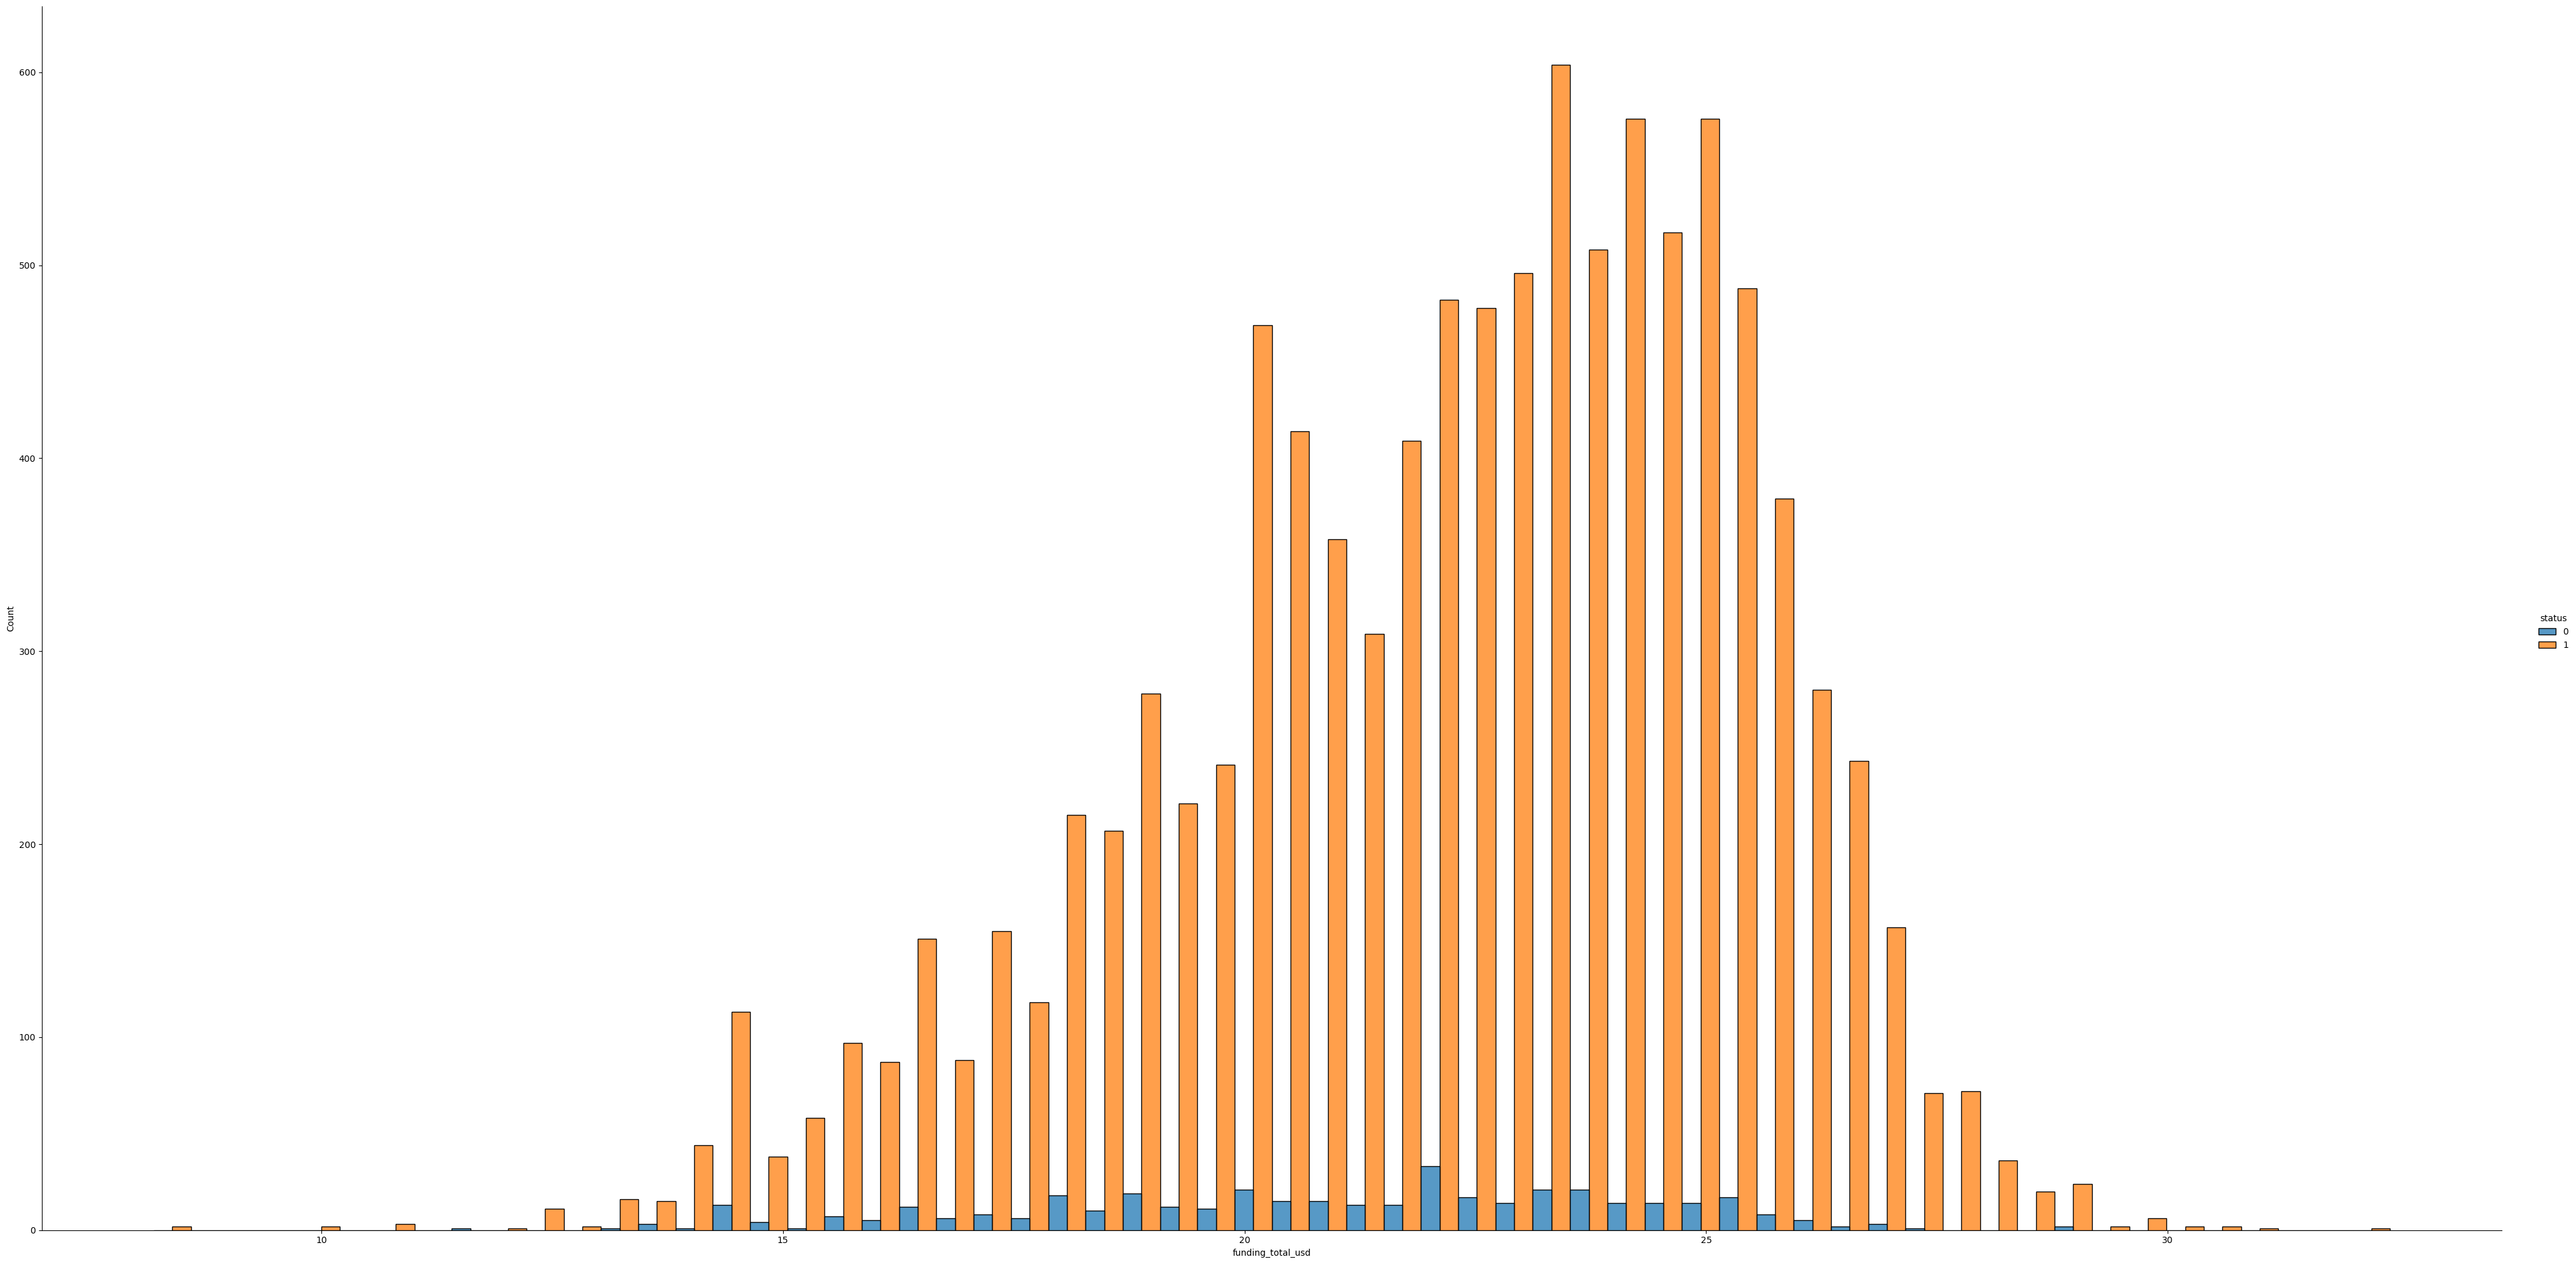

In [35]:
sb.displot(dfTarget, x='funding_total_usd', hue="status", height=20, aspect=2, multiple="dodge")

In [36]:
dfTarget

,Unnamed: 0,entity_type,category_code,status,founded_at,first_investment_at,last_investment_at,investment_rounds,invested_companies,first_funding_at,last_funding_at,funding_rounds,funding_total_usd,first_milestone_at,last_milestone_at,milestones,institution,region,state_code,country_code,latitude,longitude,twiter_categorical,web_page_categorical
0,0,Company,web,1,17/10/2005,NaN,NaN,0.0,0.0,01/10/2005,19/05/2008,3.0,25.244452,05/09/2010,18/09/2013,5.0,"University of California, Berkeley",Seattle,WA,USA,47.603122,-122.333253,1,1
1,1,Company,software,1,15/09/2005,NaN,NaN,0.0,0.0,NaN,NaN,0.0,-inf,01/01/2010,12/11/2013,5.0,"Indian Institute of Technology, Madras",SF Bay,CA,USA,37.692934,-121.904945,1,1
2,2,Company,news,1,11/10/2004,NaN,NaN,0.0,0.0,01/10/2005,12/07/2011,4.0,25.423422,08/01/2010,04/12/2013,8.0,"University of Nevada, Las Vegas",SF Bay,CA,USA,37.764726,-122.394523,1,1
3,5,Company,web,1,02/06/1999,NaN,NaN,0.0,0.0,NaN,NaN,0.0,-inf,NaN,NaN,0.0,University of Minnesota-Twin Cities,SF Bay,CA,USA,37.506885,-122.247573,0,1
4,6,Company,web,1,01/06/2006,NaN,NaN,0.0,0.0,01/01/2007,19/01/2009,3.0,23.975963,15/12/2009,25/06/2012,4.0,"University of Chicago, School of Law",Los Angeles,CA,USA,34.090368,-118.393064,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23786,112682,Company,games_video,1,01/01/2012,NaN,NaN,0.0,0.0,10/09/2013,10/09/2013,1.0,18.779565,NaN,NaN,0.0,Vanderbilt University,Nashville,TN,USA,36.162277,-86.774298,1,1
23787,112684,Company,other,1,01/01/2012,NaN,NaN,0.0,0.0,30/07/2013,30/07/2013,1.0,23.838459,13/05/2013,21/11/2013,2.0,Stanford University,SF Bay,CA,USA,37.779026,-122.419906,1,1
23788,112686,Company,education,1,,NaN,NaN,0.0,0.0,12/12/2013,12/12/2013,1.0,22.052584,NaN,NaN,0.0,The University of Western Ontario - Richard Iv...,Seattle,WA,USA,47.603832,-122.330062,0,1
23789,112692,Company,advertising,1,,NaN,NaN,0.0,0.0,NaN,NaN,0.0,-inf,NaN,NaN,0.0,Sydney Graduate School of Management,Sydney,NaN,AUS,-33.869844,151.208285,1,1


Na osnovu ovog grafika mozemo vidjeti da kako startup dobije vise novca da vjerovatnoca da ce on biti uspjesan se povecava.

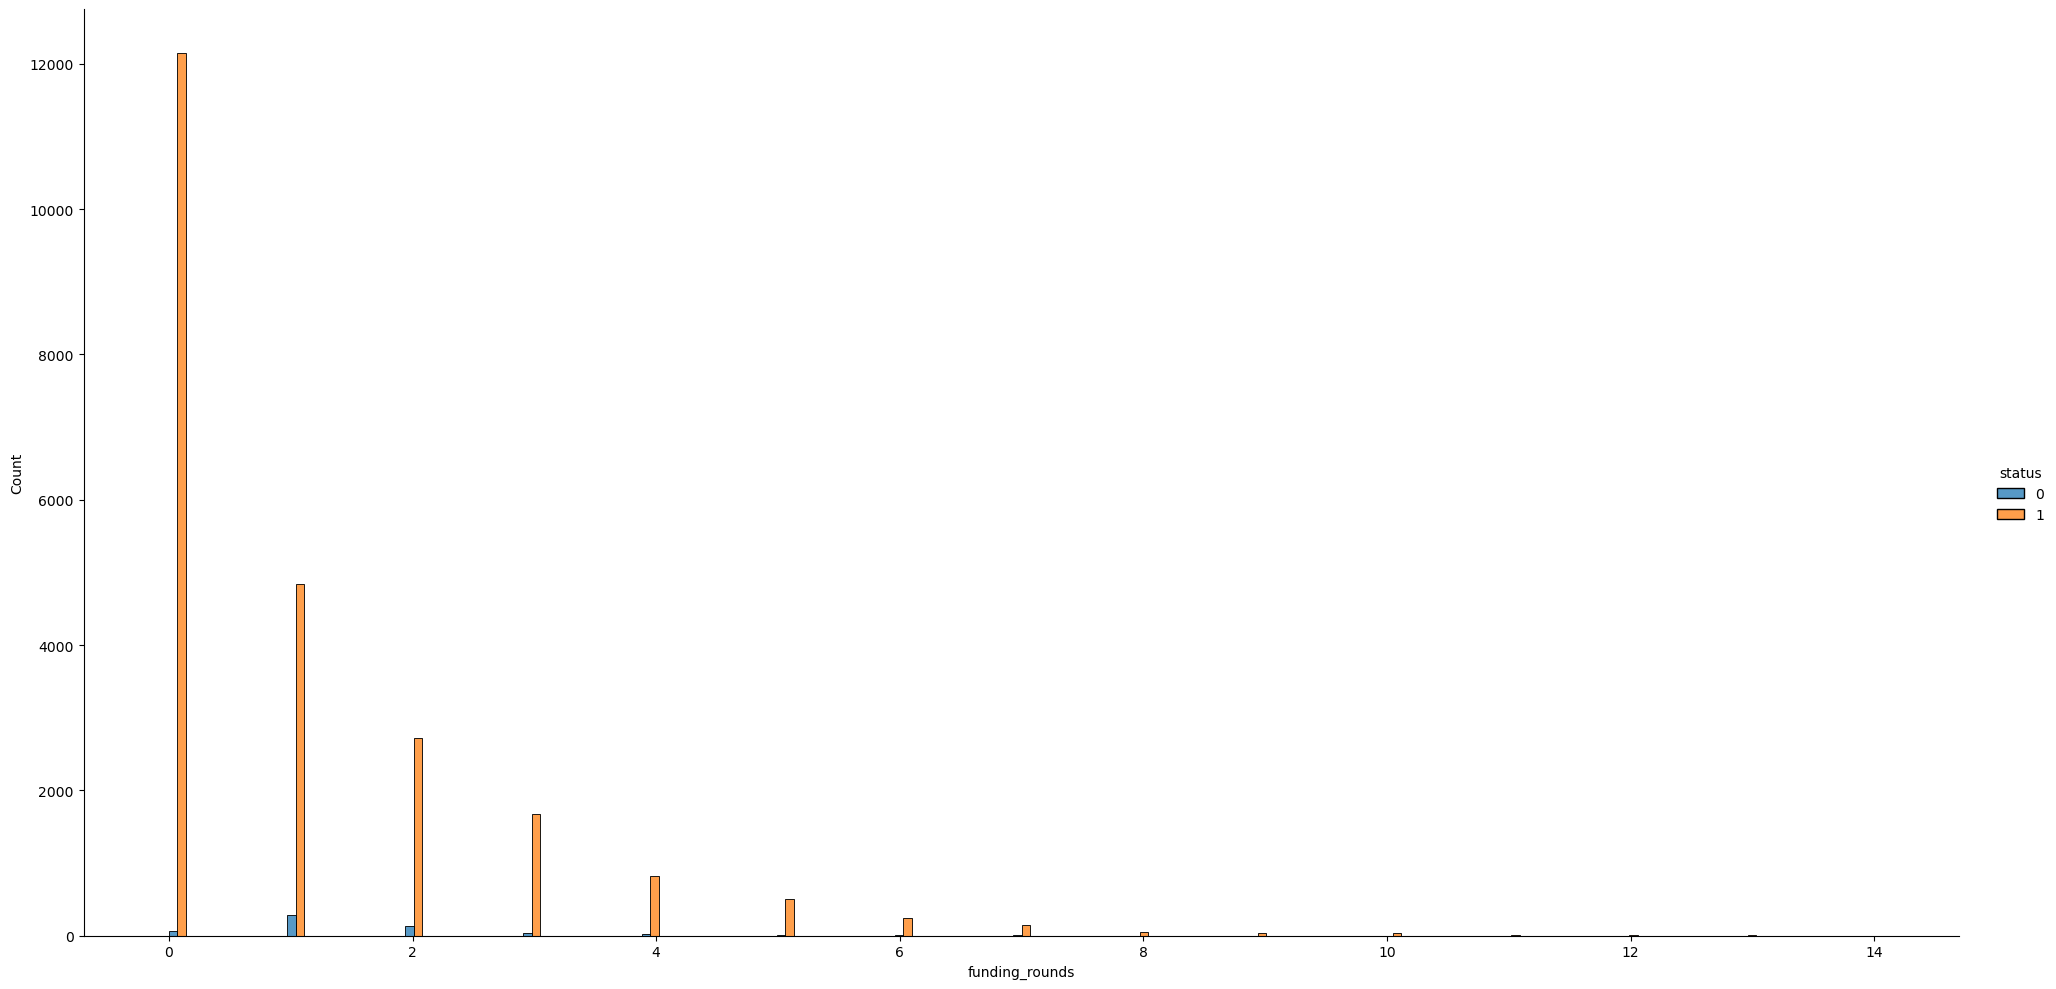

In [37]:
%matplotlib inline
sb.displot(dfTarget, x='funding_rounds', hue="status", height=10, aspect=2, multiple="dodge")


Odavde mozemo da vidimo da vecu vjerovatnocu da budu neuspjesni imaju startapi sa 1 i 2 funding rounds

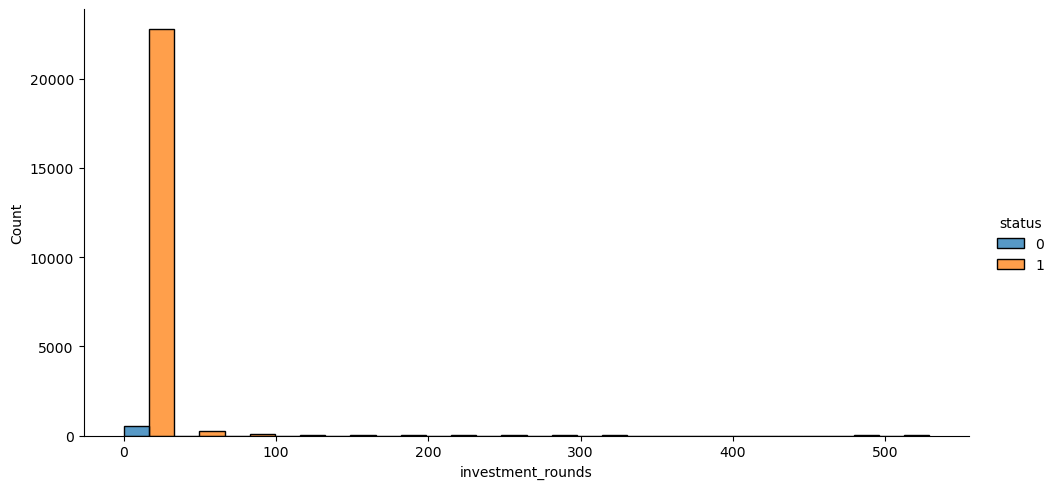

In [38]:
%matplotlib inline
sb.displot(dfTarget, x='investment_rounds', hue="status", height=5, aspect=2, multiple="dodge")

Na osnovu grafika mozemo da vidimo da imamo potencijalne outliere u ovoj koloni. Sada mozemo da izvrsimo analizu outlier-a na osnovu mediana i prikazemo to na boxplot-u.

In [39]:
def find_outliers(dataframe,column_name,is_outlier_column_name):
    median = dfTarget[column_name].median()

    # Calculate the interquartile range (IQR)
    Q1 = dataframe[column_name].quantile(0.25)
    Q3 = dataframe[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Define a function to identify outliers based on the median and IQR
    def is_outlier(x):
        if x < (median - 1.5 * IQR) or x > (median + 1.5 * IQR):
            return True
        else:
            return False

    # Apply the function to the column and create a new boolean column to indicate whether each value is an outlier
    dataframe[is_outlier_column_name] = dataframe[column_name].apply(is_outlier)

    # Visualize the outliers using a boxplot
    plt.boxplot(dataframe[column_name][dataframe[is_outlier_column_name]], notch=True, vert=False)
    plt.show()


In [40]:
# find_outliers(dfTarget,'investment_rounds','is_investment_rounds_outlier')
# dfTarget.is_investment_rounds_outlier.value_counts()

In [41]:
#dfTarget.drop(dfTarget[(dfTarget.is_investment_rounds_outlier)==True].index,inplace=True)

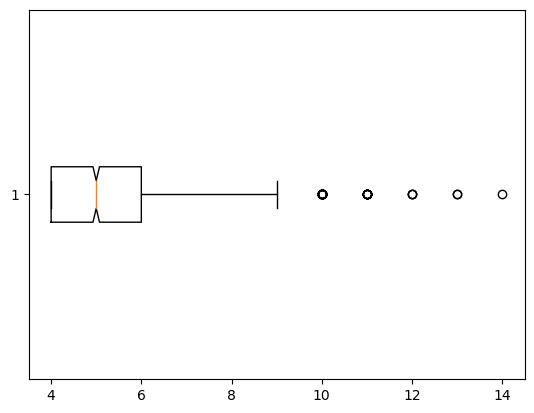

False    21895
True      1896
Name: is_funding_round_outlier, dtype: int64

In [42]:
find_outliers(dfTarget,'funding_rounds','is_funding_round_outlier')
dfTarget.is_funding_round_outlier.value_counts()

In [43]:
dfTarget.drop(dfTarget[(dfTarget.is_funding_round_outlier)==True].index,inplace=True)

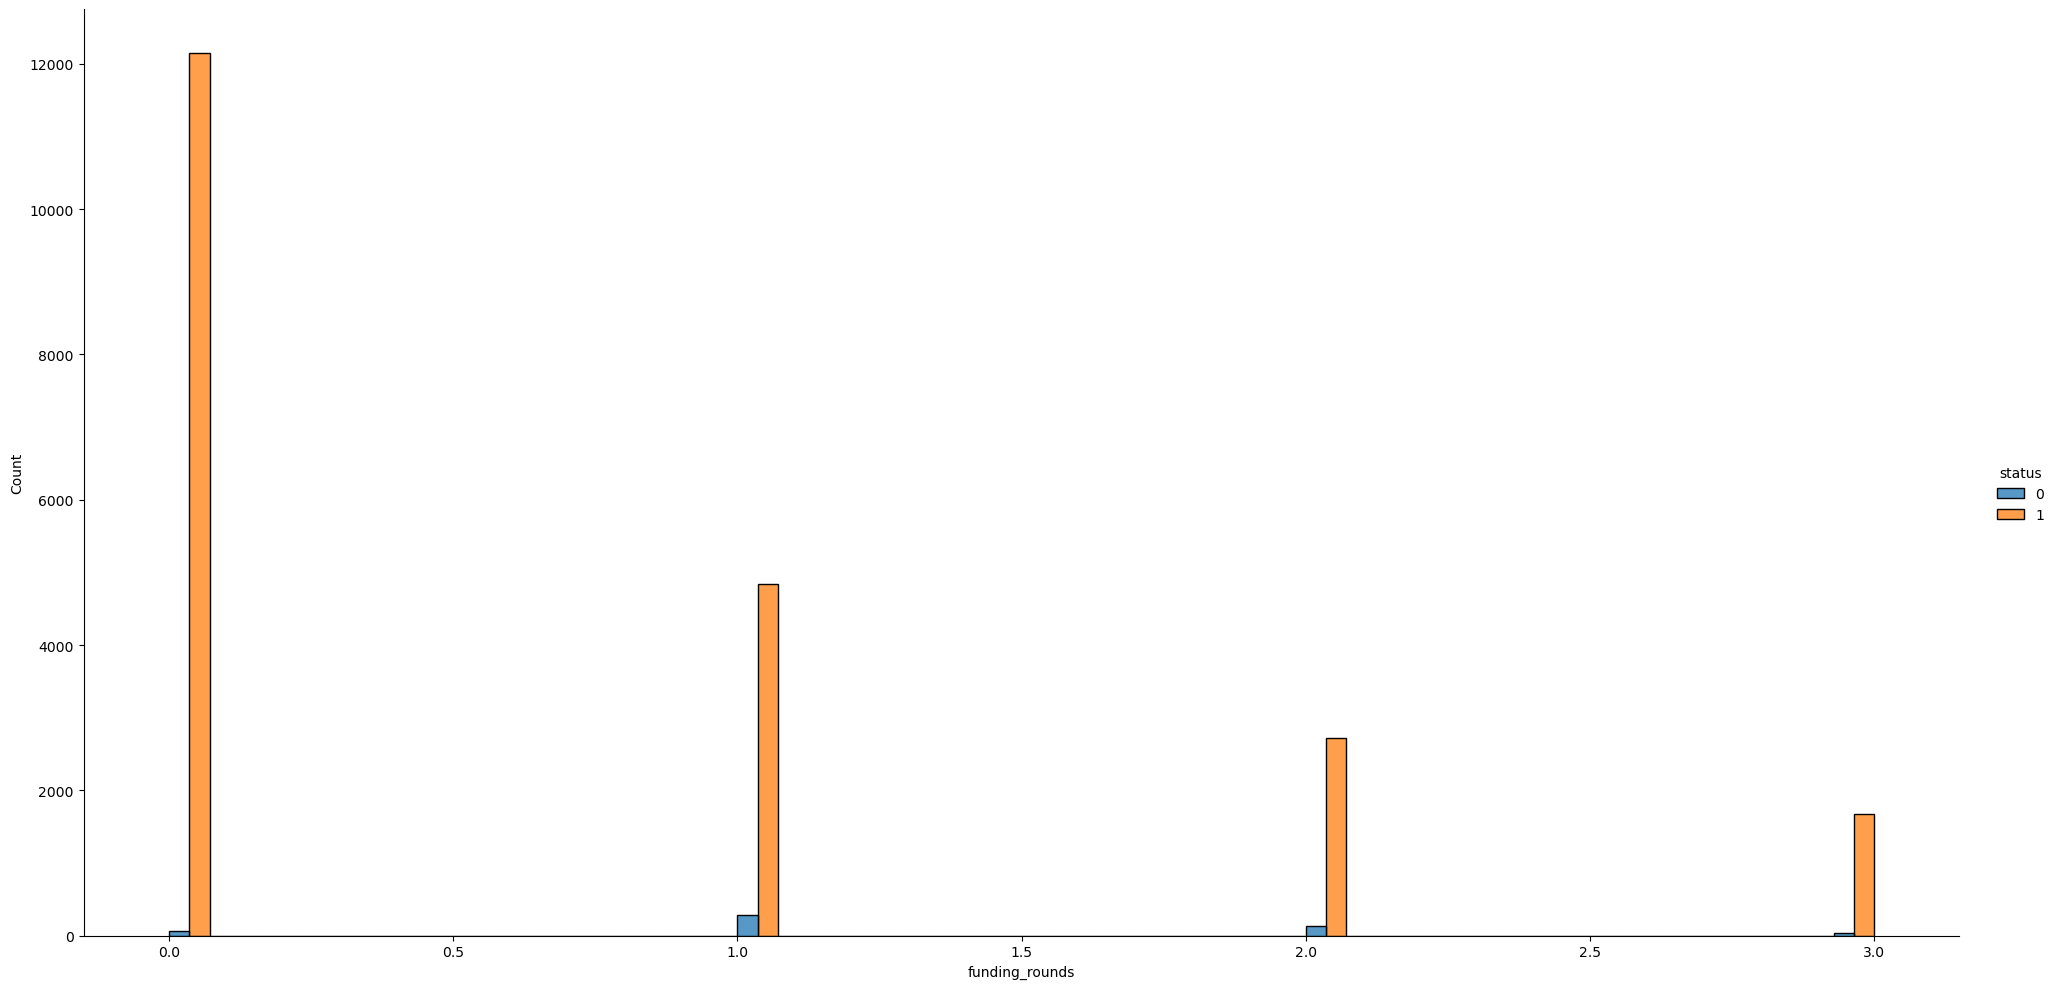

In [44]:
%matplotlib inline
sb.displot(dfTarget, x='funding_rounds', hue="status", height=10, aspect=2, multiple="dodge")

In [45]:
pandas.pivot_table(dfTarget, values = ['status'], index = ['funding_rounds'], aggfunc = [len, np.sum, np.mean])

,len,sum,mean
,status,status,status
funding_rounds,,,
0.0,12211,12149,0.994923
1.0,5126,4836,0.943426
2.0,2858,2725,0.953464
3.0,1700,1668,0.981176


Moze se zakljuciti da najvecu vjerovatnocu za neuspjeh startapi imaju kada su u prvoj i drugoj funding rundi.

Sada mozemo da vidimo da su outlieri izbaceni uspjesno

In [46]:

dfUnivercity = dfUnivercity.rename(columns={'Institution': 'institution'})

In [47]:
def fuzzy_merge1(df_1, df_2, key1, key2, threshold, limit,filename):
    
    s = df_2[key2].tolist()

    m = df_1[key1].apply(lambda x: process.extract(x, s, limit=limit))
    
    m2 = m.apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    
    m2.to_csv('fuzzy_universities_90/'+filename+'.csv', sep='\t')

    return m2

In [48]:
# batch_size = 100
# num_records = len(dfTarget)

# for i in range(0, num_records, batch_size):
#     subsetDfTarget = dfTarget.iloc[i:i+batch_size]
#     result=fuzzy_merge1(subsetDfTarget, dfUnivercity, 'institution', 'institution', 90, 1,str(i))


In [49]:
dfFuzzyUniversities=pandas.read_csv('file_90.csv',low_memory=False,sep='\t')
dfFuzzyUniversities = dfFuzzyUniversities.rename(columns={'Unnamed: 0': 'id'})
dfFuzzyUniversities = dfFuzzyUniversities.rename(columns={'institution': 'institution_fuzzy'})
dfFuzzyUniversities.isna().sum()
dfFuzzyUniversities
dfTarget

,Unnamed: 0,entity_type,category_code,status,founded_at,first_investment_at,last_investment_at,investment_rounds,invested_companies,first_funding_at,last_funding_at,funding_rounds,funding_total_usd,first_milestone_at,last_milestone_at,milestones,institution,region,state_code,country_code,latitude,longitude,twiter_categorical,web_page_categorical,is_funding_round_outlier
0,0,Company,web,1,17/10/2005,NaN,NaN,0.0,0.0,01/10/2005,19/05/2008,3.0,25.244452,05/09/2010,18/09/2013,5.0,"University of California, Berkeley",Seattle,WA,USA,47.603122,-122.333253,1,1,False
1,1,Company,software,1,15/09/2005,NaN,NaN,0.0,0.0,NaN,NaN,0.0,-inf,01/01/2010,12/11/2013,5.0,"Indian Institute of Technology, Madras",SF Bay,CA,USA,37.692934,-121.904945,1,1,False
3,5,Company,web,1,02/06/1999,NaN,NaN,0.0,0.0,NaN,NaN,0.0,-inf,NaN,NaN,0.0,University of Minnesota-Twin Cities,SF Bay,CA,USA,37.506885,-122.247573,0,1,False
4,6,Company,web,1,01/06/2006,NaN,NaN,0.0,0.0,01/01/2007,19/01/2009,3.0,23.975963,15/12/2009,25/06/2012,4.0,"University of Chicago, School of Law",Los Angeles,CA,USA,34.090368,-118.393064,1,1,False
5,7,Company,games_video,1,,NaN,NaN,0.0,0.0,NaN,NaN,0.0,-inf,NaN,NaN,0.0,Tulane University,Los Angeles,CA,USA,34.025958,-118.379768,0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23786,112682,Company,games_video,1,01/01/2012,NaN,NaN,0.0,0.0,10/09/2013,10/09/2013,1.0,18.779565,NaN,NaN,0.0,Vanderbilt University,Nashville,TN,USA,36.162277,-86.774298,1,1,False
23787,112684,Company,other,1,01/01/2012,NaN,NaN,0.0,0.0,30/07/2013,30/07/2013,1.0,23.838459,13/05/2013,21/11/2013,2.0,Stanford University,SF Bay,CA,USA,37.779026,-122.419906,1,1,False
23788,112686,Company,education,1,,NaN,NaN,0.0,0.0,12/12/2013,12/12/2013,1.0,22.052584,NaN,NaN,0.0,The University of Western Ontario - Richard Iv...,Seattle,WA,USA,47.603832,-122.330062,0,1,False
23789,112692,Company,advertising,1,,NaN,NaN,0.0,0.0,NaN,NaN,0.0,-inf,NaN,NaN,0.0,Sydney Graduate School of Management,Sydney,NaN,AUS,-33.869844,151.208285,1,1,False


In [50]:
dfTarget=dfTarget.merge(dfFuzzyUniversities,left_index=True , right_on='id', how='left')

In [51]:
dfTarget= dfTarget.merge(dfUnivercity, left_on='institution_fuzzy' , right_on='institution', how='left')


In [52]:
dfTarget.isna().sum()

Unnamed: 0                      0
entity_type                     0
category_code                   0
status                          0
founded_at                      0
first_investment_at         19543
last_investment_at          19543
investment_rounds               0
invested_companies              0
first_funding_at            12245
last_funding_at             12245
funding_rounds                  0
funding_total_usd               0
first_milestone_at           5047
last_milestone_at            5047
milestones                      0
institution_x                   0
region                          0
state_code                   7747
country_code                    0
latitude                        0
longitude                       0
twiter_categorical              0
web_page_categorical            0
is_funding_round_outlier        0
id                              0
institution_fuzzy            7652
institution_y                7652
Score                        7652
dtype: int64

In [53]:
#medianScore = dfTarget['Score'].median()
#dfTarget['Score'].fillna(medianScore, inplace=True)
dfTarget.Score=pandas.to_numeric(dfTarget.Score)

In [54]:
dfTarget['status'].value_counts()

1    21378
0      517
Name: status, dtype: int64

In [55]:
dfTarget.isna().sum()

Unnamed: 0                      0
entity_type                     0
category_code                   0
status                          0
founded_at                      0
first_investment_at         19543
last_investment_at          19543
investment_rounds               0
invested_companies              0
first_funding_at            12245
last_funding_at             12245
funding_rounds                  0
funding_total_usd               0
first_milestone_at           5047
last_milestone_at            5047
milestones                      0
institution_x                   0
region                          0
state_code                   7747
country_code                    0
latitude                        0
longitude                       0
twiter_categorical              0
web_page_categorical            0
is_funding_round_outlier        0
id                              0
institution_fuzzy            7652
institution_y                7652
Score                        7652
dtype: int64

In [56]:
dfTarget.Score=dfTarget.Score.fillna(0)
dfNegative=dfTarget[(dfTarget['status']==0) & (dfTarget.Score==0)]

In [57]:
dfNegative.to_csv('negative.csv')
dfTarget.to_csv('podaci sa univerzitetima')

PermissionError: [Errno 13] Permission denied: 'negative.csv'

In [ ]:
%matplotlib inline
sb.displot(dfTarget, x='Score', hue="status", height=10, aspect=2, multiple="dodge")

In [58]:
pandas.pivot_table(dfTarget, values = ['status'], index = ['Score'], aggfunc = [len, np.sum, np.mean])

,len,sum,mean
,status,status,status
Score,,,
0.0,7652,7493,0.979221
65.8,13,13,1.000000
65.9,10,9,0.900000
66.0,35,34,0.971429
66.1,18,18,1.000000
...,...,...,...
93.3,93,90,0.967742
94.1,87,86,0.988506


In [59]:
y = dfTarget['status']
y = dfTarget['status'].map({'operating': 1, 'acquired': 1, 'closed': 0})
X = dfTarget.drop(columns=['status'])

In [60]:
dfTarget['founded_at'].fillna('')
dfTarget['first_investment_at'].fillna('')
dfTarget['last_investment_at'].fillna('')
dfTarget['last_funding_at'].fillna('')
dfTarget['first_funding_at'].fillna('')
print(len(dfTarget[(dfTarget['founded_at']=='')]))
dfTarget.drop(dfTarget[(dfTarget['founded_at']=='')].index,inplace=True)

3514


In [61]:
dfTarget['status'].value_counts()

1    17934
0      447
Name: status, dtype: int64

In [62]:
def parse_date(df, date_col,result_month,result_year):
    
    if df[date_col].dtype != 'datetime64[ns]':
        df[date_col] = pandas.to_datetime(df[date_col],infer_datetime_format=True);
    df[result_month] = df[date_col].dt.month;
    df[result_year] = df[date_col].dt.year;
    
    return df






In [63]:
dfTarget=parse_date(dfTarget,'founded_at','founded_month','founded_year');


In [64]:
dfTarget=parse_date(dfTarget,'first_funding_at','first_funding_at_month','first_funding_at_year');
dfTarget=parse_date(dfTarget,'last_funding_at','last_funding_at_month','last_funding_at_year');
dfTarget=parse_date(dfTarget,'first_investment_at','first_investment_at_month','first_investment_at_year');
dfTarget=parse_date(dfTarget,'last_investment_at','last_investment_at_month','last_investment_at_year');

C:\Users\Djordje\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '18/12/2007' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\Djordje\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '29/11/2006' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\Djordje\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '24/05/2007' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\Djordje\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '28/10/2004' in DD/MM/YYYY format. Provide format o

In [65]:
dfTarget.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18381 entries, 0 to 21891
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Unnamed: 0                 18381 non-null  int64         
 1   entity_type                18381 non-null  object        
 2   category_code              18381 non-null  object        
 3   status                     18381 non-null  int64         
 4   founded_at                 18381 non-null  datetime64[ns]
 5   first_investment_at        1809 non-null   datetime64[ns]
 6   last_investment_at         1809 non-null   datetime64[ns]
 7   investment_rounds          18381 non-null  float64       
 8   invested_companies         18381 non-null  float64       
 9   first_funding_at           8698 non-null   datetime64[ns]
 10  last_funding_at            8698 non-null   datetime64[ns]
 11  funding_rounds             18381 non-null  float64       
 12  fund

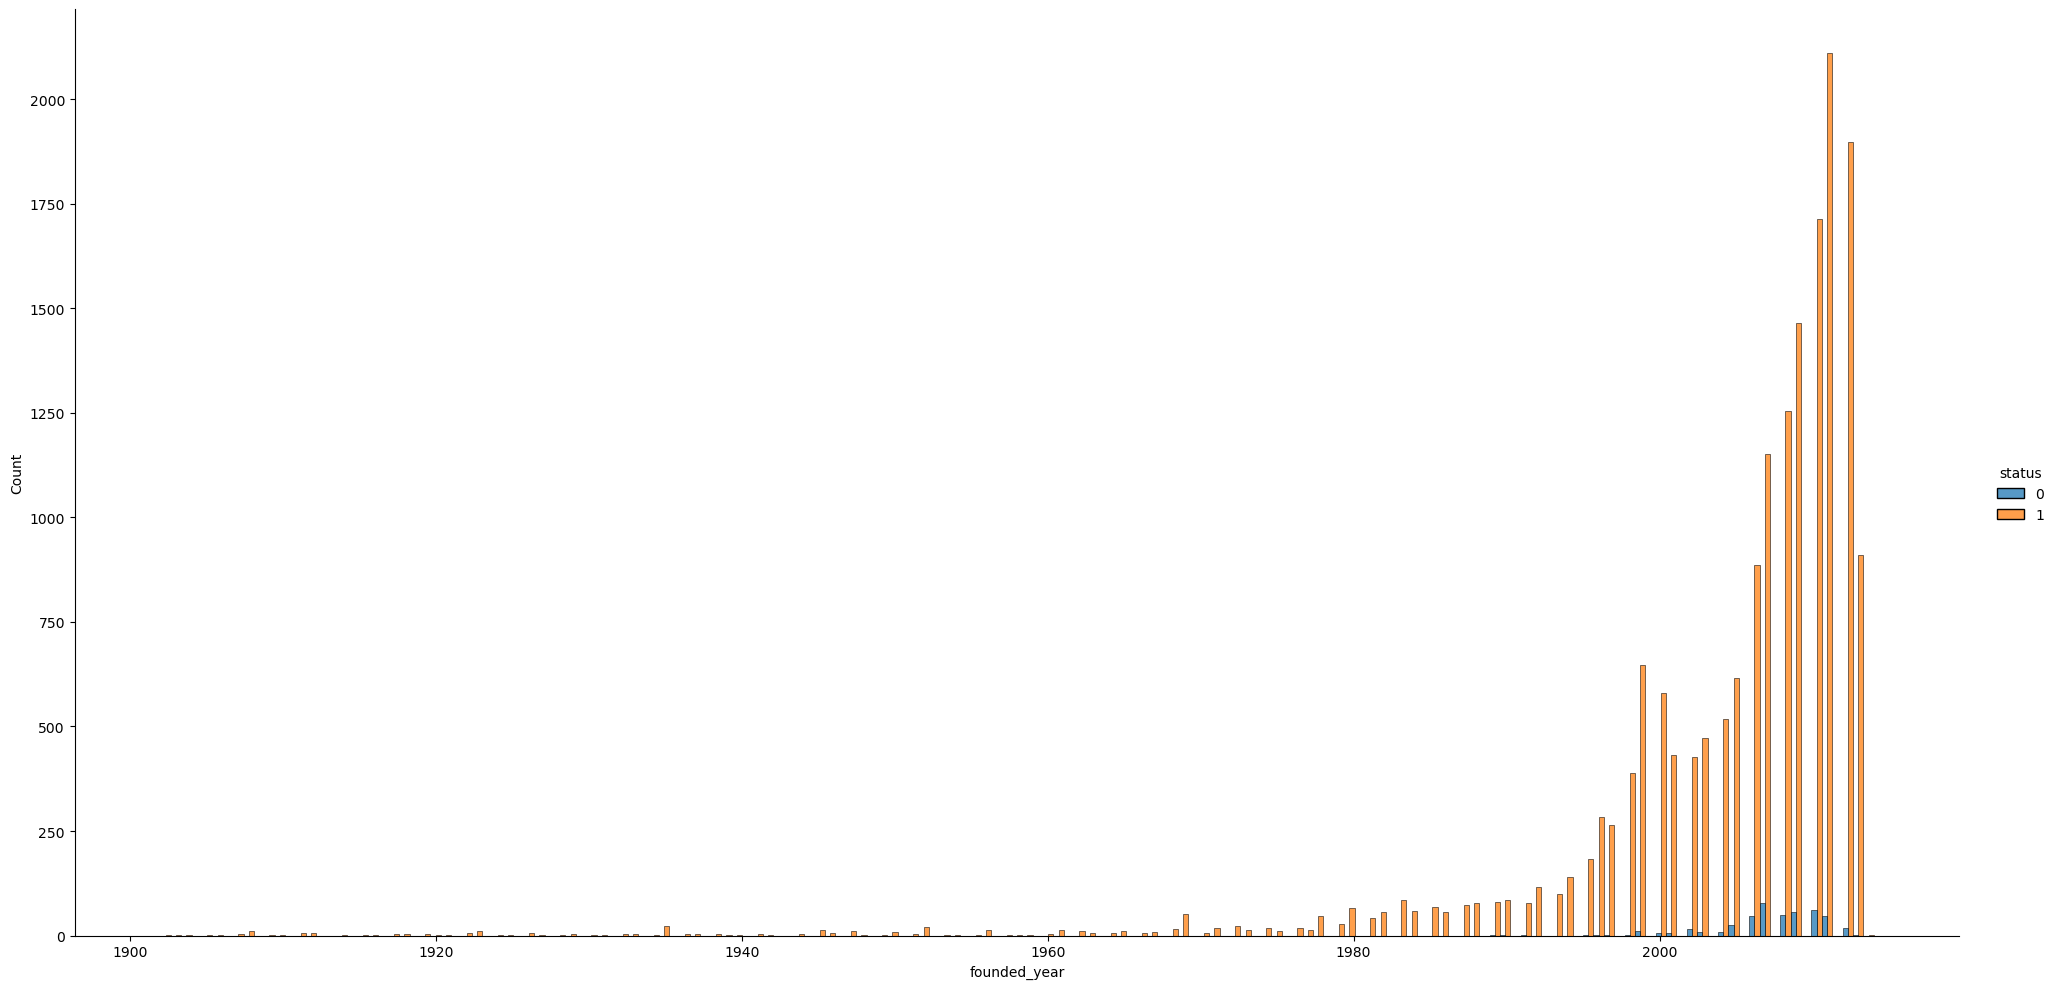

In [66]:
%matplotlib inline
sb.displot(dfTarget, x='founded_year', hue="status", height=10, aspect=2, multiple="dodge")

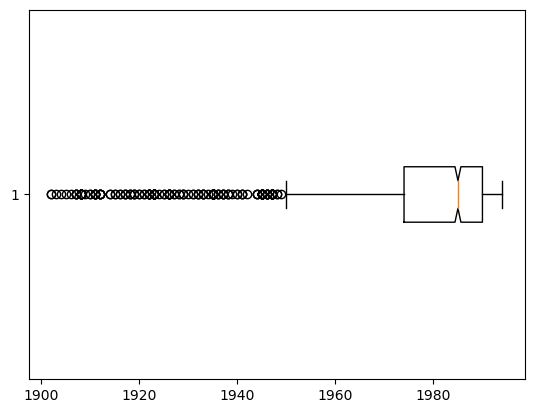

False    16643
True      1738
Name: is_founded_year_outlier, dtype: int64

In [67]:
find_outliers(dfTarget,'founded_year','is_founded_year_outlier')
dfTarget.is_founded_year_outlier.value_counts()

In [68]:
dfTarget.drop(dfTarget[(dfTarget['is_founded_year_outlier']==True)].index,inplace=True)

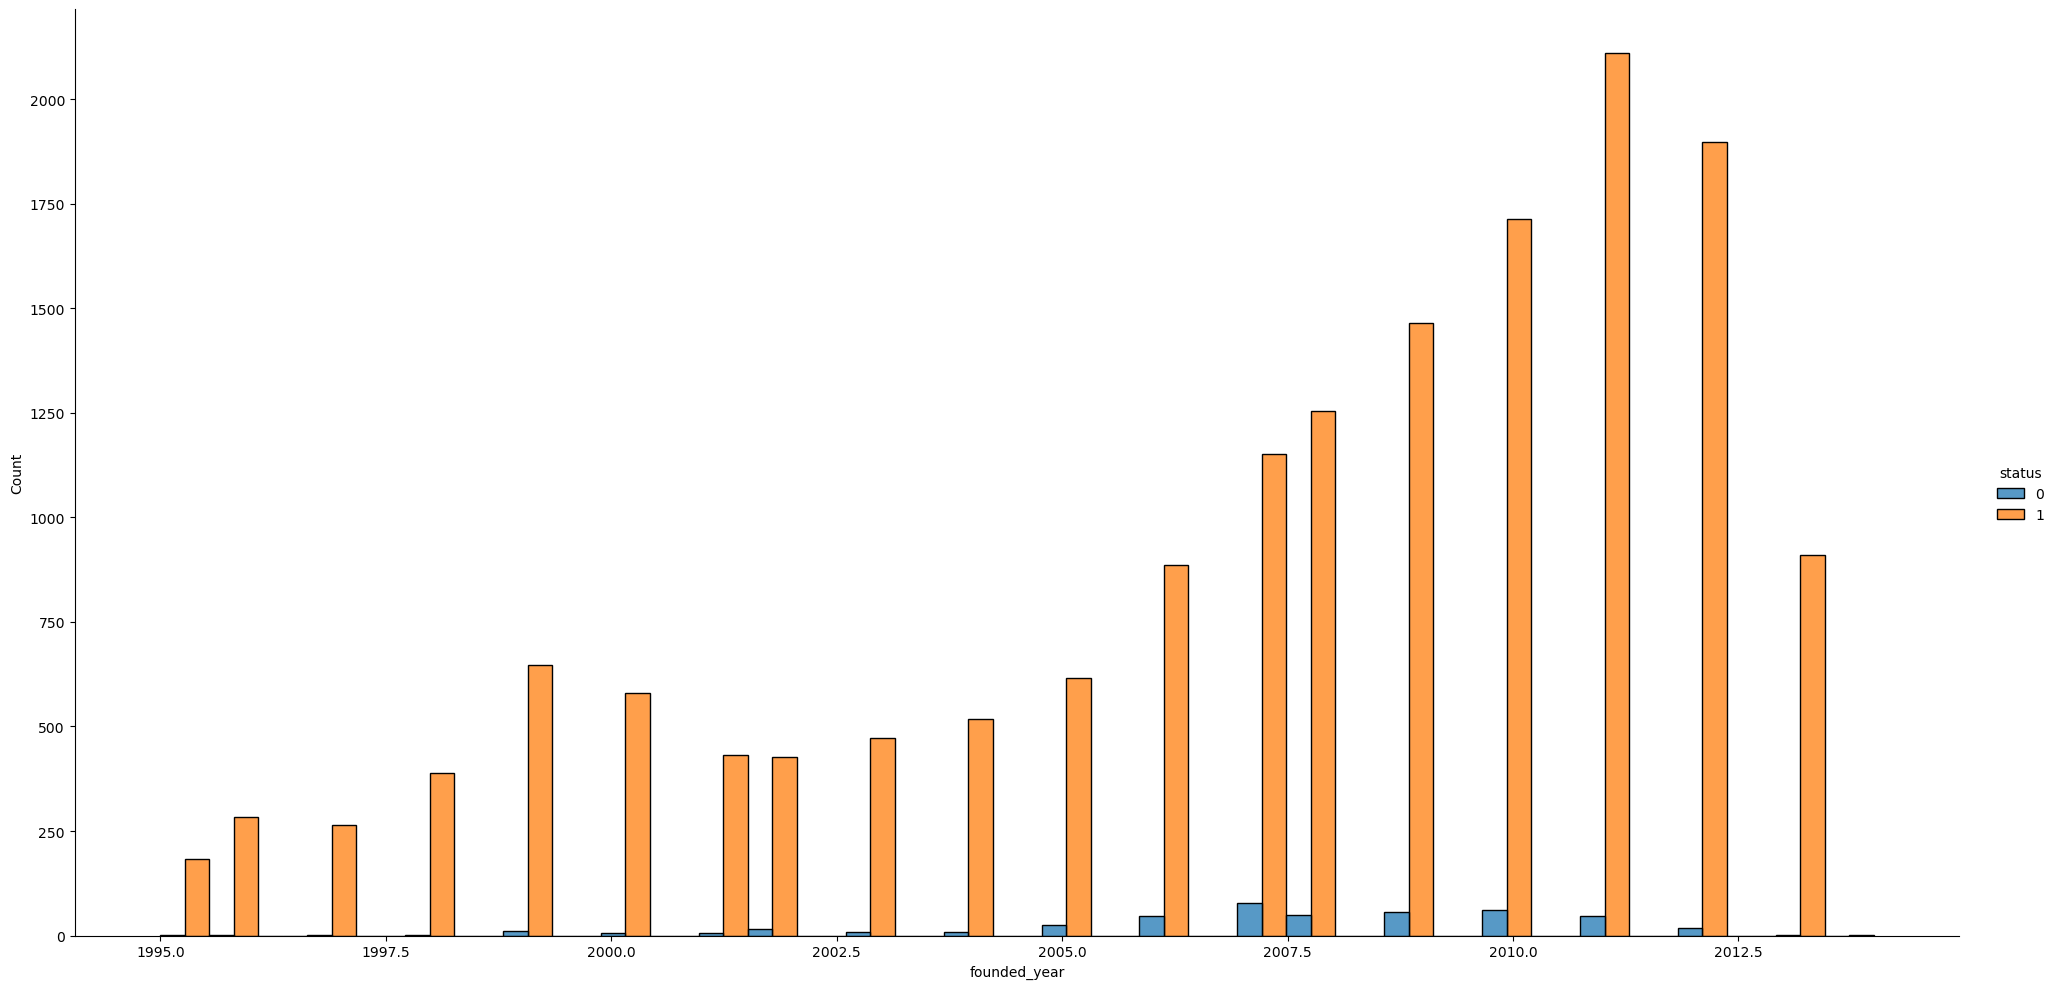

In [69]:
%matplotlib inline
sb.displot(dfTarget, x='founded_year', hue="status", height=10, aspect=2, multiple="dodge")

In [70]:
pandas.pivot_table(dfTarget, values = ['status'], index = ['founded_year'], aggfunc = [len, np.sum, np.mean])

,len,sum,mean
,status,status,status
founded_year,,,
1995,185,184,0.994595
1996,284,283,0.996479
1997,266,264,0.992481
1998,390,388,0.994872
1999,658,648,0.984802
2000,586,580,0.989761
2001,439,432,0.984055
2002,442,426,0.963801


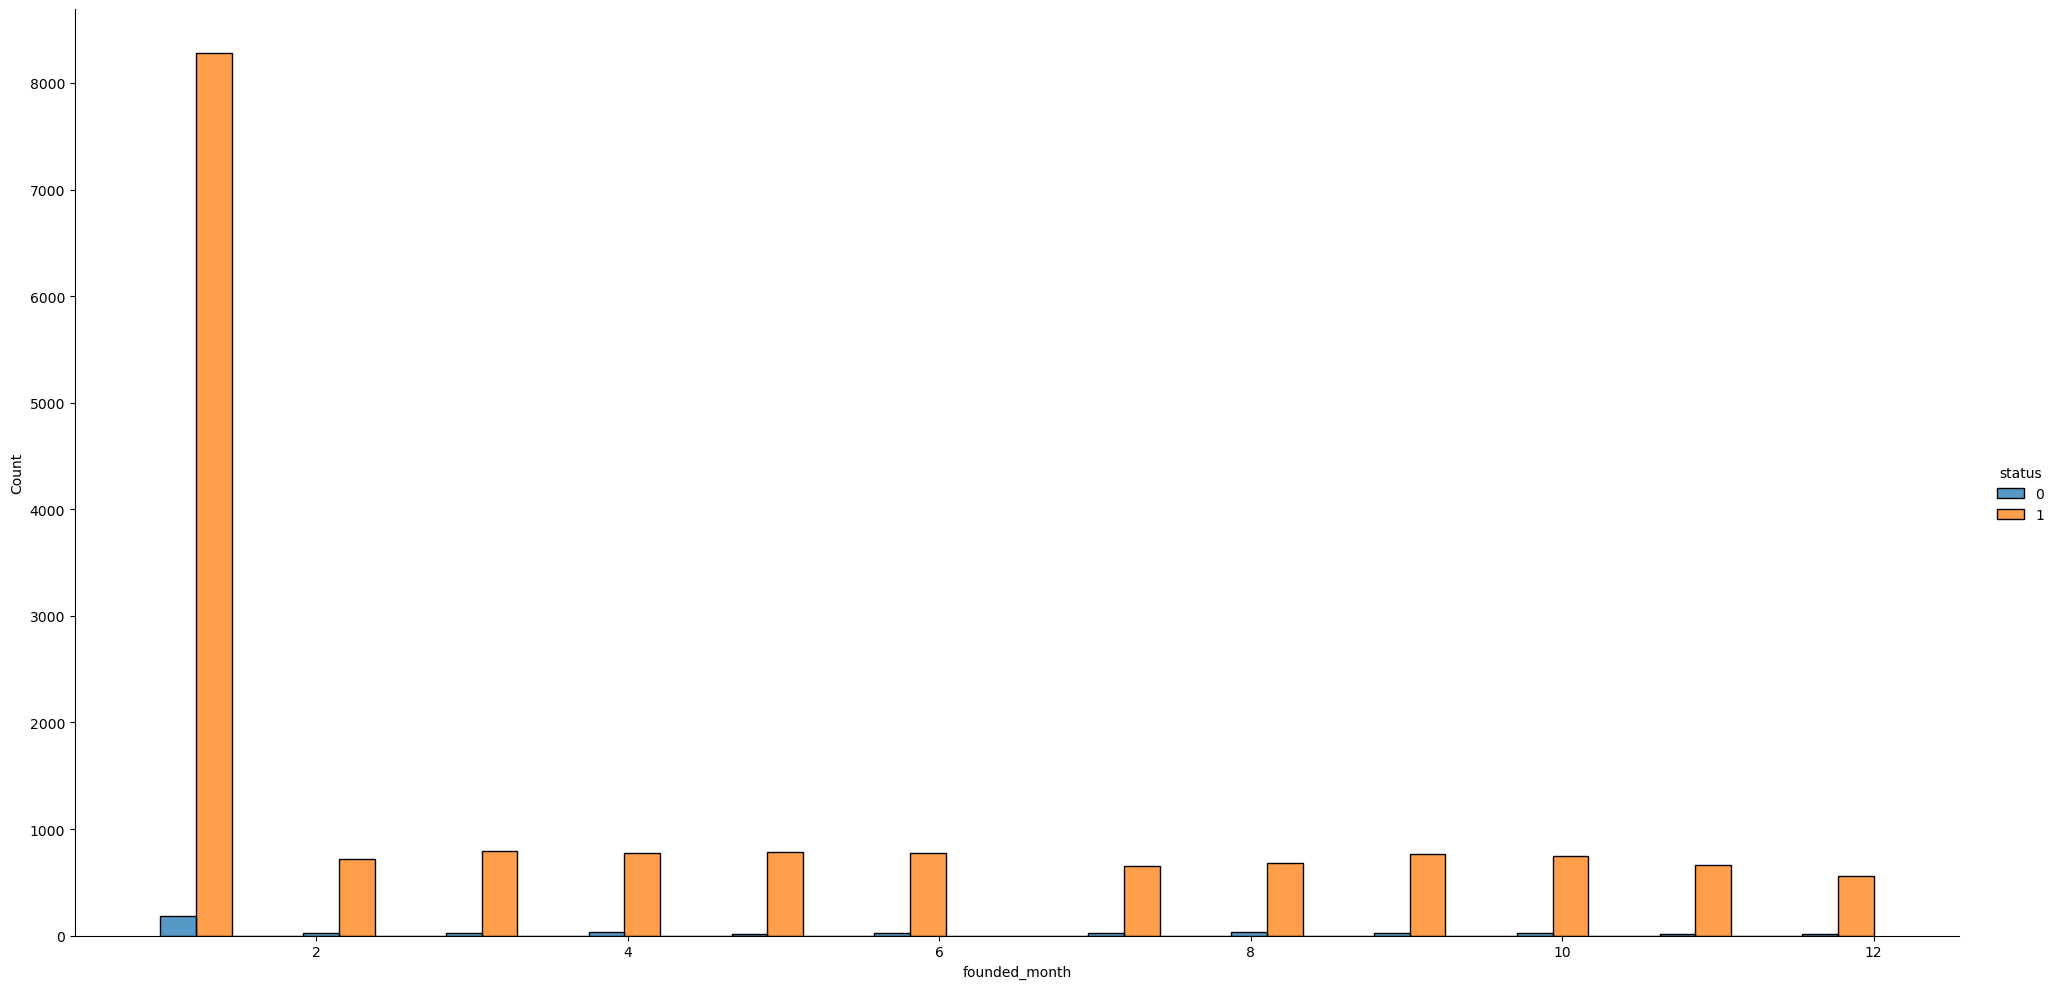

In [71]:
%matplotlib inline
sb.displot(dfTarget, x='founded_month', hue="status", height=10, aspect=2, multiple="dodge")

In [72]:
pandas.pivot_table(dfTarget, values = ['status'], index = ['founded_month'], aggfunc = [len, np.sum, np.mean])

,len,sum,mean
,status,status,status
founded_month,,,
1,8462,8280,0.978492
2,748,721,0.963904
3,812,789,0.971675
4,806,775,0.961538
5,801,786,0.981273
6,806,778,0.965261
7,682,656,0.961877
8,712,679,0.953652


In [73]:
dfTarget.columns

Index(['Unnamed: 0', 'entity_type', 'category_code', 'status', 'founded_at',
       'first_investment_at', 'last_investment_at', 'investment_rounds',
       'invested_companies', 'first_funding_at', 'last_funding_at',
       'funding_rounds', 'funding_total_usd', 'first_milestone_at',
       'last_milestone_at', 'milestones', 'institution_x', 'region',
       'state_code', 'country_code', 'latitude', 'longitude',
       'twiter_categorical', 'web_page_categorical',
       'is_funding_round_outlier', 'id', 'institution_fuzzy', 'institution_y',
       'Score', 'founded_month', 'founded_year', 'first_funding_at_month',
       'first_funding_at_year', 'last_funding_at_month',
       'last_funding_at_year', 'first_investment_at_month',
       'first_investment_at_year', 'last_investment_at_month',
       'last_investment_at_year', 'is_founded_year_outlier'],
      dtype='object')

In [74]:
dfTarget=dfTarget.drop(columns=['Unnamed: 0', 'founded_at', 'first_investment_at', 
                                'last_investment_at','institution_x','region',
                                'first_funding_at', 'last_funding_at',
                                'first_milestone_at',
                                   'last_milestone_at',
                                 'state_code', 'country_code','is_funding_round_outlier', 'id', 
                                'institution_fuzzy', 'institution_y','is_founded_year_outlier',
                                'first_investment_at_month', 'first_investment_at_year',
       'last_investment_at_month', 'last_investment_at_year'])

In [75]:
dfTarget.columns

Index(['entity_type', 'category_code', 'status', 'investment_rounds',
       'invested_companies', 'funding_rounds', 'funding_total_usd',
       'milestones', 'latitude', 'longitude', 'twiter_categorical',
       'web_page_categorical', 'Score', 'founded_month', 'founded_year',
       'first_funding_at_month', 'first_funding_at_year',
       'last_funding_at_month', 'last_funding_at_year'],
      dtype='object')

In [76]:
dfTarget.first_funding_at_year=dfTarget.first_funding_at_year.fillna(0)
dfTarget.first_funding_at_month=dfTarget.first_funding_at_month.fillna(0)
dfTarget.last_funding_at_year=dfTarget.last_funding_at_year.fillna(0)
dfTarget.last_funding_at_month=dfTarget.last_funding_at_month.fillna(0)
dfTarget['difference_funding']=dfTarget['last_funding_at_year']-dfTarget['first_funding_at_year']+abs(dfTarget['last_funding_at_month']-dfTarget['first_funding_at_month'])

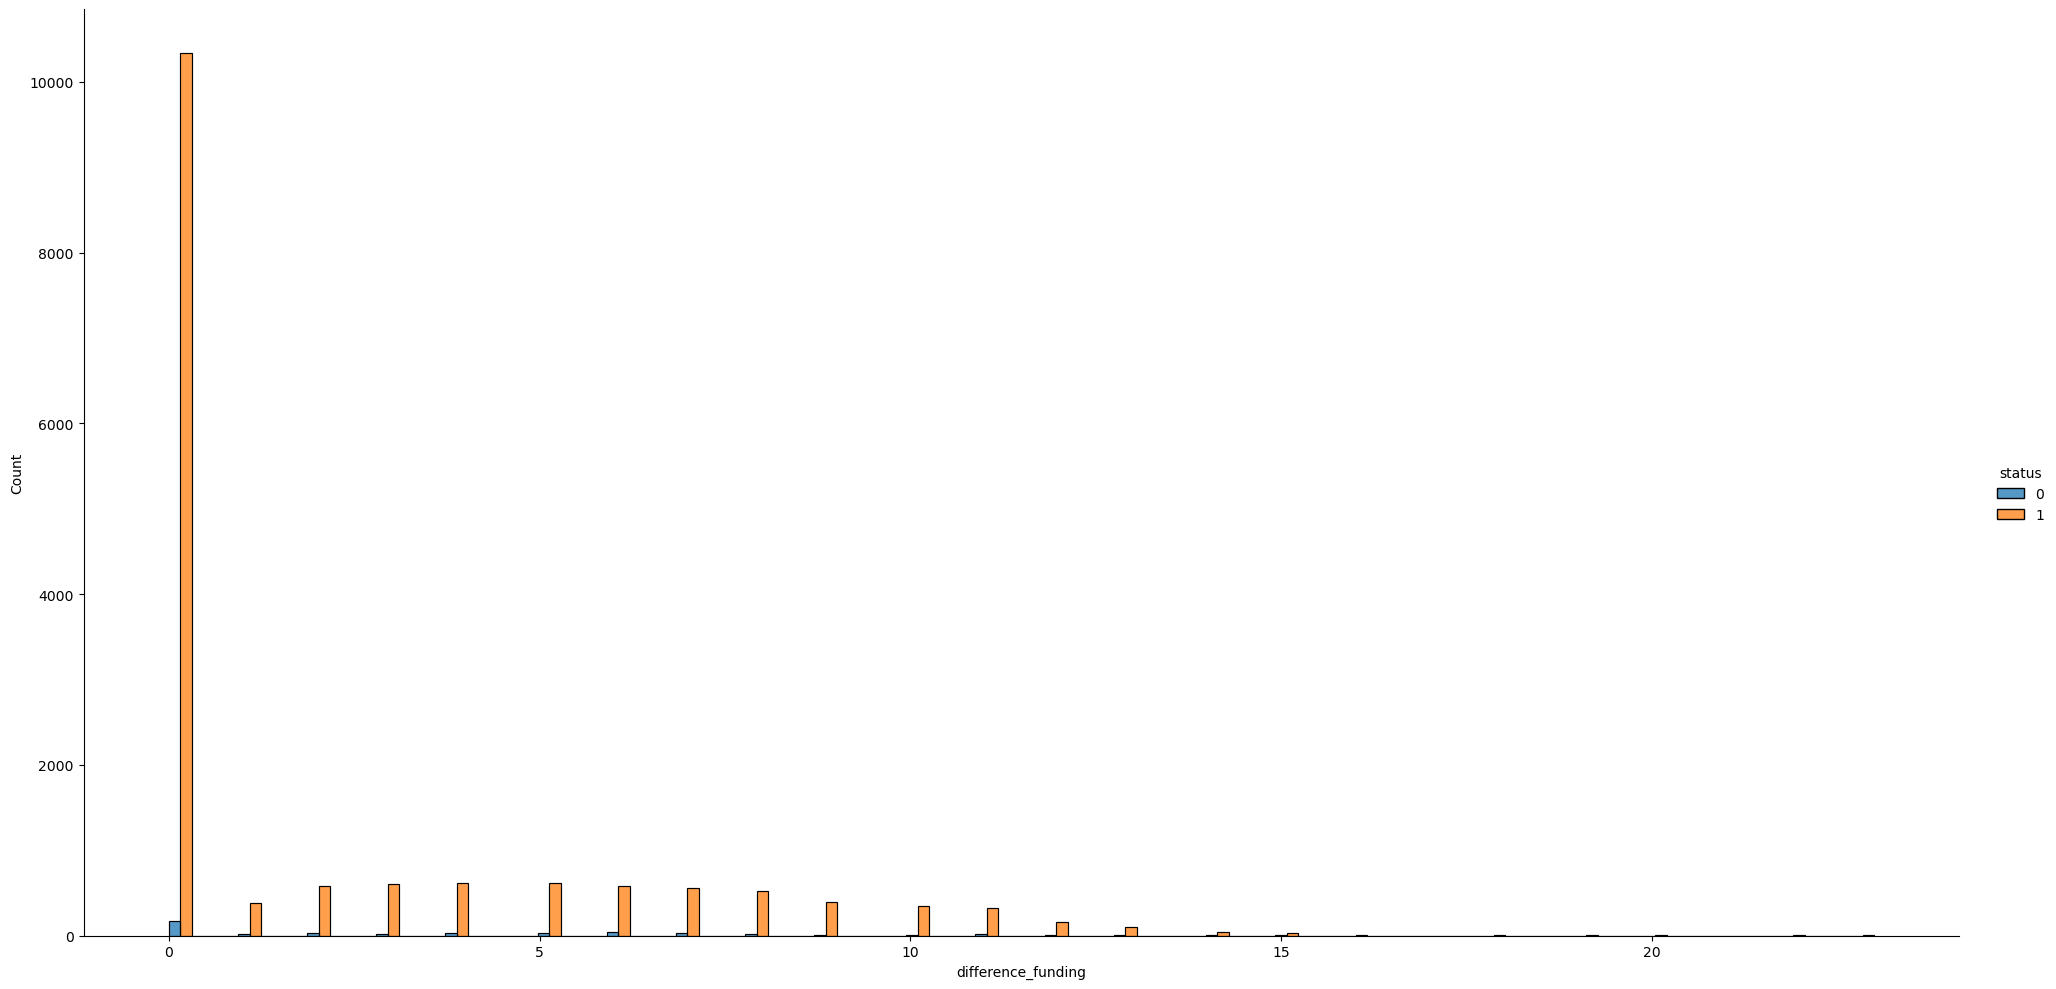

In [77]:
%matplotlib inline
sb.displot(dfTarget, x='difference_funding', hue="status", height=10, aspect=2, multiple="dodge")

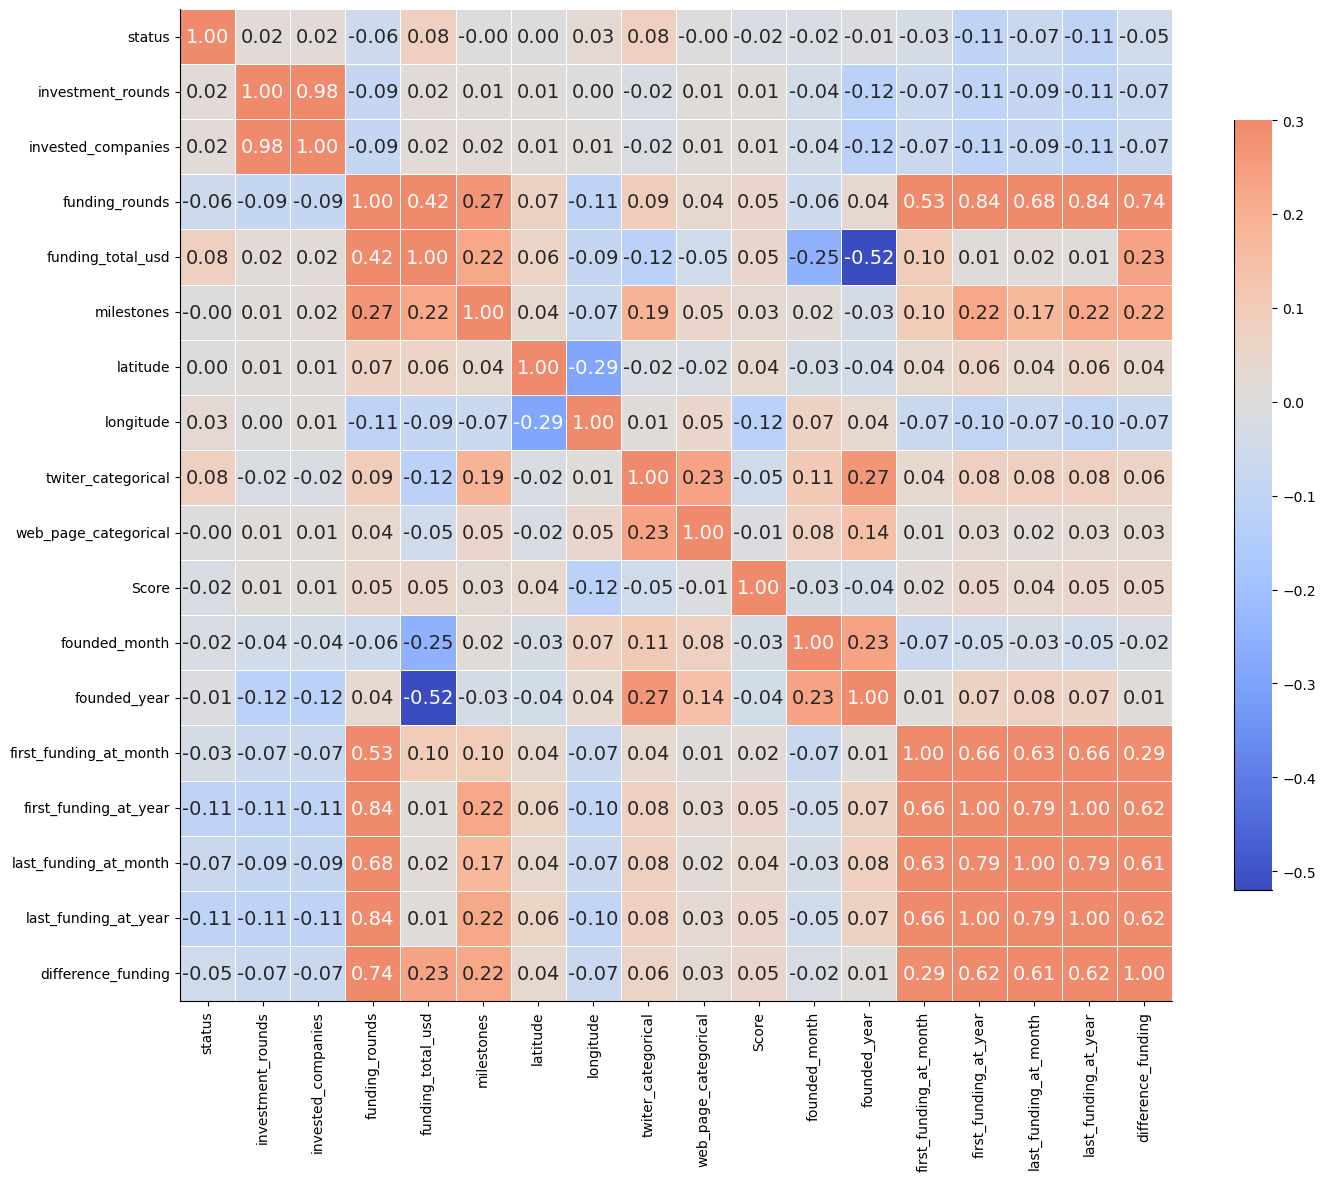

In [78]:
corr = dfTarget.corr().round(2)

plt.figure(figsize=(16, 20))
g = sb.heatmap(corr,  vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"fontsize":14})
sb.despine()

plt.show()

In [79]:
dfTarget=dfTarget.drop(columns=['first_funding_at_month','first_funding_at_year','last_funding_at_month','last_funding_at_year'])

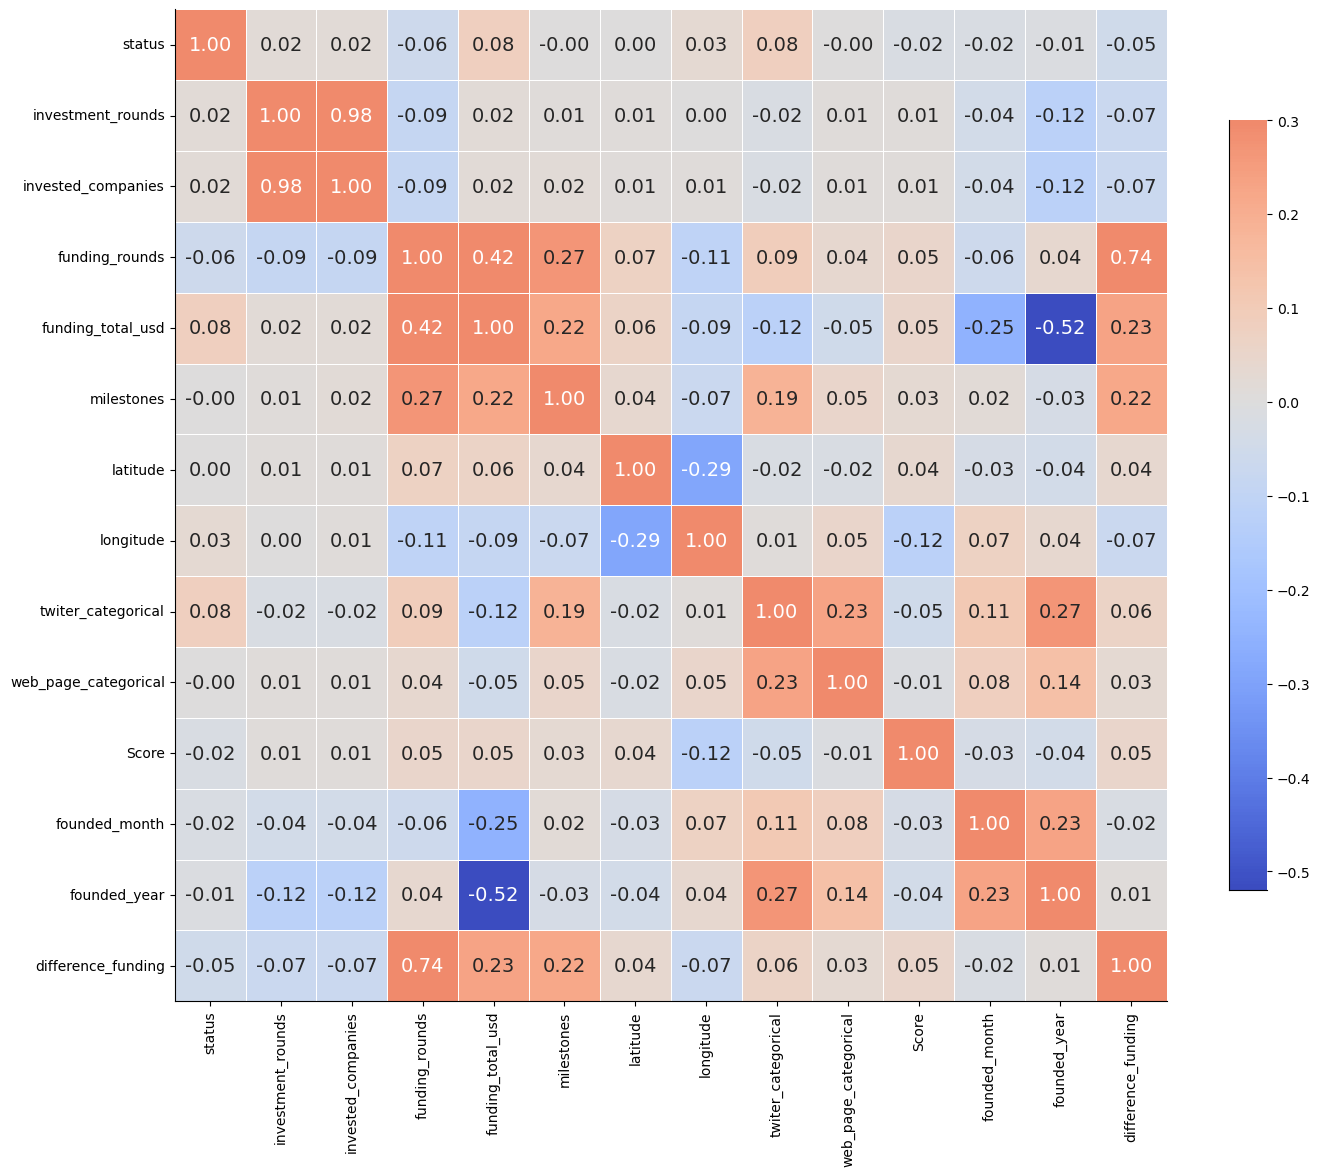

In [80]:
corr = dfTarget.corr().round(2)

plt.figure(figsize=(16, 20))
g = sb.heatmap(corr,  vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"fontsize":14})
sb.despine()

plt.show()

In [81]:
dfTarget=dfTarget.drop(columns=['invested_companies'])

Vidimo da nam ne treba invested_companies kolona jer je u korelaciji sa investemnt_rounds te cemo je izbaciti

In [82]:
categories_one_hot=pandas.get_dummies(dfTarget.category_code)
dfTarget = pandas.concat([dfTarget, categories_one_hot], axis=1)
entity_type_one_hot=pandas.get_dummies(dfTarget.entity_type)
dfTarget = pandas.concat([dfTarget, entity_type_one_hot], axis=1)

In [83]:
dfTarget.funding_total_usd=dfTarget.funding_total_usd.fillna(0)

In [84]:
dfTarget=dfTarget.drop(columns=['entity_type','category_code'])

In [87]:
dfTarget.loc[dfTarget['funding_total_usd'] < 0, 'funding_total_usd'] = 1

In [88]:
dfTarget

,status,investment_rounds,funding_rounds,funding_total_usd,milestones,latitude,longitude,twiter_categorical,web_page_categorical,Score,founded_month,founded_year,difference_funding,advertising,analytics,automotive,biotech,cleantech,consulting,design,ecommerce,education,enterprise,fashion,finance,...,manufacturing,medical,messaging,mobile,music,nanotech,network_hosting,news,nonprofit,other,pets,photo_video,public_relations,real_estate,search,security,semiconductor,social,software,sports,transportation,travel,web,Company,FinancialOrg
0,1,0.0,3.0,25.244452,5.0,47.603122,-122.333253,1,1,90.1,10,2005,7.0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,1,0.0,0.0,1.000000,5.0,37.692934,-121.904945,1,1,73.5,9,2005,0.0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,1,0.0,0.0,1.000000,0.0,37.506885,-122.247573,0,1,84.8,6,1999,0.0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,1,0.0,3.0,23.975963,4.0,34.090368,-118.393064,1,1,0.0,6,2006,2.0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
6,1,0.0,0.0,1.000000,0.0,34.057498,-118.446596,0,1,0.0,2,2005,0.0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21881,1,0.0,1.0,15.095067,1.0,0.000000,0.000000,1,1,84.6,4,2013,0.0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
21884,1,0.0,0.0,1.000000,0.0,34.019470,-118.491227,1,1,69.1,1,2013,0.0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
21887,1,0.0,1.0,1.000000,0.0,52.205531,0.118664,0,1,81.8,1,2011,1.0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
21890,1,0.0,1.0,18.779565,0.0,36.162277,-86.774298,1,1,84.5,1,2012,1.0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [89]:
normalized_df=(dfTarget-dfTarget.min())/(dfTarget.max()-dfTarget.min())

In [90]:
normalized_df['status'].value_counts()

1.0    16199
0.0      444
Name: status, dtype: int64

In [91]:
normalized_df.isna().sum()

status                  0
investment_rounds       0
funding_rounds          0
funding_total_usd       0
milestones              0
latitude                0
longitude               0
twiter_categorical      0
web_page_categorical    0
Score                   0
founded_month           0
founded_year            0
difference_funding      0
advertising             0
analytics               0
automotive              0
biotech                 0
cleantech               0
consulting              0
design                  0
ecommerce               0
education               0
enterprise              0
fashion                 0
finance                 0
games_video             0
government              0
hardware                0
health                  0
hospitality             0
legal                   0
local                   0
manufacturing           0
medical                 0
messaging               0
mobile                  0
music                   0
nanotech                0
network_host

In [107]:
normalized_df.to_csv('normalized_final.csv')

In [92]:
y = normalized_df['status']
X = normalized_df.drop(columns=['status'])

## Undersampling

In [93]:
dfTarget.to_csv('final_data1.csv')

PermissionError: [Errno 13] Permission denied: 'final_data1.csv'

In [94]:
def undersamping(X, y):
    print("Klasna raspodela pre undersamplinga:", Counter(y))
    rus = RandomUnderSampler(random_state=42)

    X_res, y_res = rus.fit_resample(X, y)

    print("Klasna raspodela posle undersamplinga:", Counter(y_res))
    return X_res, y_res

## Oversampling 

In [95]:
def oversampling(X, y):
    # Primena SMOTE algoritma za oversampling podataka
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)

    # Prikaz balansiranih podataka
    balanced_df = pandas.concat([pandas.DataFrame(X_res), pandas.DataFrame(y_res, columns=['target'])], axis=1)
    print(balanced_df['target'].value_counts())
    return X_res, y_res

## Podela dataseta na test, train i validacioni - 80:10:10

In [96]:
def dataset_partitioning(X_balanced, y_balanced):
    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.111, random_state=42, stratify=y_balanced)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

    print('Broj ciljnih vrednosti \'closed\' u trening skupu:', np.sum(y_train==0))
    print('Broj ciljnih vrednosti \'closed\' u test skupu:', np.sum(y_test==0))
    print('Broj ciljnih vrednosti \'closed\' u validacionom skupu:', np.sum(y_val==0))
    return X_train, y_train, X_test, y_test, X_val, y_val
    

## Random Forest algoritam

In [97]:
def random_forest(X_train, y_train, X_test, y_test, n_estimator): # Kreiraj instancu Random Forest klasifikatora sa 10 stabala
    rfc = RandomForestClassifier(n_estimators=n_estimator)

    # Obuči model na X_train i y_train podacima
    rfc.fit(X_train, y_train)

    # Predvidi klase za X_train i X_test podatke
    y_train_pred = rfc.predict(X_train)
    y_test_pred = rfc.predict(X_test)

    # Izračunaj tačnost modela
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print("Train Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)
    print(y_test_pred)
    return y_test_pred

## Linearna regresija

In [98]:
def linear_regression(X_train, y_train, X_test, y_test):
    reg = LinearRegression()

    # Obuči model na trening podacima
    reg.fit(X_train, y_train)

    # Predvidi vrednosti za test podatke
    y_pred = reg.predict(X_test)

    # Izračunaj srednju kvadratnu grešku
    mse = mean_squared_error(y_test, y_pred)

    # Prikaz rezultata
    print("Koeficijenti regresije:", reg.coef_)
    print("Intercept:", reg.intercept_)
    print("Srednja kvadratna greška:", mse)
    print("-----")
    print(y_pred)
    return y_pred

## Precision, recall i F1 mera

In [99]:
def get_precision_recall_f1score_for_minority_class(y_test, y_test_pred):
    # Izvlacenje **manjiske klase**
    y_test1 = np.array(y_test)
    y_test_pred1 = np.array(y_test_pred)

    # Izdvajanje indeksa gde se nalaze vrednosti 0 u y_test
    idx = np.where(y_test1 == 0)[0]

    # Izdvajanje samo vrednosti 0 iz y_test i y_test_pred pomocu indeksa
    y_test1 = y_test1[idx]
    y_test_pred1 = y_test_pred1[idx]

    precision = precision_score(y_test1, y_test_pred1, pos_label=0)
    recall = recall_score(y_test1, y_test_pred1, pos_label=0)
    f1 = f1_score(y_test1, y_test_pred1, pos_label=0)

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1-score: ", f1)

In [100]:
def get_precision_recall_f1score(y_test, y_test_pred):
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1-score: ", f1)

## Algoritmi nad undersamplovanim podacima

In [101]:
X_undersampling, y_undersampling = undersamping(X, y)
#TODO SD: obrisati
X_undersampling.to_csv('undersampling_x.csv', index=False)
y_undersampling.to_csv('undersampling_y.csv', index=False)
print("---")
X_train_u, y_train_u, X_test_u, y_test_u, X_val_u, y_val_u = dataset_partitioning(X_undersampling, y_undersampling)

Klasna raspodela pre undersamplinga: Counter({1.0: 16199, 0.0: 444})
Klasna raspodela posle undersamplinga: Counter({0.0: 444, 1.0: 444})
---
Broj ciljnih vrednosti 'closed' u trening skupu: 355
Broj ciljnih vrednosti 'closed' u test skupu: 50
Broj ciljnih vrednosti 'closed' u validacionom skupu: 39


### Random Forest

In [102]:
y_rnd_forest_u_pred = random_forest(X_train_u, y_train_u, X_test_u, y_test_u, 10)
print("*** Precision recall i f1 mera nad celim skupom ***")
get_precision_recall_f1score(y_test_u, y_rnd_forest_u_pred)
print("*** Precision recall i f1 mera nad manjinskoj klasi ***")
get_precision_recall_f1score_for_minority_class(y_test_u, y_rnd_forest_u_pred)

Train Accuracy: 0.9901408450704225
Test Accuracy: 0.7676767676767676
[0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0.
 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1.
 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 1.]
*** Precision recall i f1 mera nad celim skupom ***
Precision:  0.8095238095238095
Recall:  0.6938775510204082
F1-score:  0.7472527472527472
*** Precision recall i f1 mera nad manjinskoj klasi ***
Precision:  1.0
Recall:  0.84
F1-score:  0.9130434782608696



### Linearna regresija 

In [103]:
y_lr_u_pred = linear_regression(X_train_u, y_train_u, X_test_u, y_test_u)

Koeficijenti regresije: [-1.80843463e-01 -3.19586112e-02 -1.83912425e-01  1.31142486e-01
  4.09898272e-02  1.14528334e-01  2.49582524e-01  1.04177202e-02
 -3.38506411e-02 -9.24722143e-02 -1.12399551e-01 -8.09546974e-02
 -1.68637641e+12 -1.68637641e+12 -1.68637641e+12 -1.68637641e+12
 -1.68637641e+12 -1.68637641e+12  7.61536945e+08 -1.68637641e+12
 -1.68637641e+12 -1.68637641e+12 -1.68637641e+12 -1.68637641e+12
 -1.68637641e+12 -3.61955654e+07 -1.68637641e+12 -1.68637641e+12
 -1.68637641e+12 -1.68637641e+12  1.86099060e+06 -1.68637641e+12
 -1.68637641e+12 -1.68637641e+12 -1.68637641e+12 -1.68637641e+12
 -1.68637641e+12 -1.68637641e+12 -1.68637641e+12 -1.68637641e+12
 -1.68637641e+12 -1.68637641e+12 -1.68637641e+12 -1.68637641e+12
 -1.68637641e+12 -1.68637641e+12 -1.68637641e+12 -1.68637641e+12
 -1.68637641e+12 -1.68637641e+12 -1.68637641e+12 -1.68637641e+12
 -1.68637641e+12 -1.68637641e+12 -6.88415277e+11 -6.88415277e+11]
Intercept: 2374791685907.658
Srednja kvadratna greška: 2.87259764

## Algoritmi nad oversamplovanim podacima

In [104]:
X_oversampling, y_oversampling = oversampling(X, y)
#TODO SD: obrisati
X_oversampling.to_csv('oversampling_x.csv', index=False)
y_oversampling.to_csv('oversampling_y.csv', index=False)
print("---")
X_train_o, y_train_o, X_test_o, y_test_o, X_val_o, y_val_o = dataset_partitioning(X_oversampling, y_oversampling)

Series([], Name: target, dtype: int64)
---
Broj ciljnih vrednosti 'closed' u trening skupu: 12960
Broj ciljnih vrednosti 'closed' u test skupu: 1799
Broj ciljnih vrednosti 'closed' u validacionom skupu: 1440


### Random Forest

In [105]:
y_rnd_forest_o_pred = random_forest(X_train_o, y_train_o, X_test_o, y_test_o, 10)
print("*** Precision recall i f1 mera nad celim skupom ***")
get_precision_recall_f1score(y_test_o, y_rnd_forest_o_pred)
print("*** Precision recall i f1 mera nad manjinskoj klasi ***")
get_precision_recall_f1score_for_minority_class(y_test_o, y_rnd_forest_o_pred)

Train Accuracy: 0.9996527777777777
Test Accuracy: 0.9813733666944676
[0. 0. 0. ... 0. 0. 0.]
*** Precision recall i f1 mera nad celim skupom ***
Precision:  0.9854178351093662
Recall:  0.9771968854282537
F1-score:  0.9812901424183189
*** Precision recall i f1 mera nad manjinskoj klasi ***
Precision:  1.0
Recall:  0.9855475264035576
F1-score:  0.9927211646136619


### Linearna regresija

In [106]:
y_lr_o_pred = linear_regression(X_train_o, y_train_o, X_test_o, y_test_o)

Koeficijenti regresije: [-2.92480449e-01 -1.92618122e-01 -2.25497227e-01  2.35937334e-01
  3.89924034e-02  2.15472944e-01  2.65933728e-01 -2.16566578e-01
 -2.93018854e-02 -8.11684478e-02 -1.03523335e-01 -5.18574341e-02
  3.47010190e+11  3.47010190e+11  3.47010190e+11  3.47010190e+11
  3.47010190e+11  3.47010190e+11  3.47010190e+11  3.47010190e+11
  3.47010190e+11  3.47010190e+11  3.47010190e+11  3.47010190e+11
  3.47010190e+11  3.47010190e+11  3.47010190e+11  3.47010190e+11
  3.47010190e+11  3.47010190e+11  3.47010190e+11  3.47010190e+11
  3.47010190e+11  3.47010190e+11  3.47010190e+11  3.47010190e+11
  3.47010190e+11  3.47010190e+11  3.47010190e+11  3.47010190e+11
  3.47010190e+11  3.47010190e+11  3.47010190e+11  3.47010190e+11
  3.47010190e+11  3.47010190e+11  3.47010190e+11  3.47010190e+11
  3.47010190e+11  3.47010190e+11  3.47010190e+11  3.47010190e+11
  3.47010190e+11  3.47010190e+11  5.57077779e+12  5.57077779e+12]
Intercept: -5917787980932.499
Srednja kvadratna greška: 0.1894196